<a href="https://colab.research.google.com/github/simsekergun/PMS/blob/main/PythonModeSolver_AllExamples.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install writefile

  Preparing metadata (setup.py) ... done
  Created wheel for writefile: filename=writefile-0.2-py3-none-any.whl size=2883 sha256=32849cb94c4ac4ca7c4e01ff2396fd96d2685410edbb7a16e5a0132c273ee4d7
  Stored in directory: /root/.cache/pip/wheels/db/e7/e2/f4b16217226f859bff63f7b6205862ddce1d4c72a015982184
Successfully built writefile


In [2]:
%%writefile _material_base.py

import numpy as np
from scipy import constants as spc
from scipy import interpolate as spi
import abc
from functools import wraps
from six import with_metaclass


class _Material(with_metaclass(abc.ABCMeta)):
    '''
    Abstract material class that can calculate many
    material properties based on the permittivity.

    Args:
        wlMinNm (float): The minimum wavelength [nm].
        wlMaxNm (float): The maximum wavelength [nm].
    '''
    def __init__(self, wlMinNm=300., wlMaxNm=5000.):
        self._wlMin = wlMinNm
        self._wlMax = wlMaxNm

        self._wls = np.linspace(self._wlMin, self._wlMax, 100, False)
        self._wlStep = (self._wlMax-self._wlMin)/100.

        self.nDer1Func = None
        self.nDer2Func = None

    def _convertWavelengthUnitsNm(self, wavelength):
        if wavelength is not False and wavelength is not None:
            if np.all(wavelength <= self._wlMax * 1.e-9):
                wlFactor = 1.e9
            elif np.all(wavelength <= self._wlMax * 1.e-3):
                wlFactor = 1.e3
            else:
                wlFactor = 1.
            wl = wavelength * wlFactor
            assert(np.all(wl >= self._wlMin) and np.all(wl <= self._wlMax)), \
                'Wavelength not in range %.1f nm to %.1f nm.' % (self._wlMin, self._wlMax)
        else:
            wl = wavelength
        return wl

    def convertWavelengthUnitsNm(func):
        @wraps(func)
        def _convertWavelengthUnitsNmWrapper(self, wavelength):
            wl = self._convertWavelengthUnitsNm(wavelength)
            return func(self, wl)
        return _convertWavelengthUnitsNmWrapper

    @abc.abstractproperty
    def _eps(self, wavelength=None):
        '''
        The permittivty of the desired material.

        Each new material needs this method implemented.

        Args:
            wavelength (float, list, None): The wavelength the permittivty
                will be evaluated at.

        Returns:
            float, list: The permittivty at the target wavelength.
        '''
        return NotImplementedError

    @convertWavelengthUnitsNm
    def eps(self, wavelength=None):
        '''
        The permittivty of the desired material.

        Args:
            wavelength (float, list, None): The wavelength the permittivty
                will be evaluated at.

        Returns:
            float, list: The permittivty at the target wavelength.
        '''
        return self._eps(wavelength)

    def _nDer1(self, wavelength):
        if not self.nDer1Func:
            nDer1 = np.gradient(self.n(self._wls), self._wlStep) # [1/nm]
            self.nDer1Func = spi.interp1d(self._wls, nDer1)
        return self.nDer1Func(wavelength) * 1.e9  # [1/nm] -> [1/m]

    def _nDer2(self, wavelength):
        if not self.nDer2Func:
            nDer2 = np.gradient(self._nDer1(self._wls), self._wlStep)  # [1/(nm)^2]
            self.nDer2Func = spi.interp1d(self._wls, nDer2)
        return self.nDer2Func(wavelength) * 1.e9  # [1/(nm)^2] -> [1/m]

    def n(self, wavelength=None):
        '''
        The refractive index of the desired material.

        Args:
            wavelength (float, list, None): The wavelength the refractive index
                will be evaluated at.

        Returns:
            float, list: The refractive index at the target wavelength.
        '''
        return self.eps(wavelength)**0.5

    # dn/dlambda
    def nDer1(self, wavelength):
        '''
        The first derivative of the refractive index with respect to
        wavelength.

        Args:
            wavelength (float, list, None): The wavelength(s) the derivative
                will be evaluated at.

        Returns:
            float, list: The refractive index at the target wavelength(s).
        '''
        return self._nDer1(wavelength)

    # d^2n/dlambda^2
    def nDer2(self, wavelength):
        '''
        The second derivative of the refractive index with respect to
        wavelength.

        Args:
            wavelength (float, list, None): The wavelength(s) the derivative
                will be evaluated at.

        Returns:
            float, list: The refractive index at the target wavelength(s).
        '''
        return self._nDer2(wavelength)

    # n_g: group velocity index
    @convertWavelengthUnitsNm
    def ng(self, wavelength):
        '''
        The group index of the material.

        Args:
            wavelength (float, list, None): The wavelength(s) the group
                index will be evaluated at.

        Returns:
            float, list: The group index at the target wavelength(s).
        '''
        return self.n(wavelength) - (wavelength*1.e-9)*self.nDer1(wavelength)

    # Group velocity (v_g)
    def vg(self, wavelength):
        '''
        The group velocity of the material.

        Args:
            wavelength (float, list, None): The wavelength(s) the group
                velocities will be evaluated at.

        Returns:
            float, list: The group velocities at the target wavelength(s).
        '''
        return spc.c / self.ng(wavelength)

    # Group velocity dispersion (GVD)
    # beta_2 = lambda^3/(2 pi c^2) * d^2n/dlambda^2
    @convertWavelengthUnitsNm
    def gvd(self, wavelength):
        '''
        The group velocity dispersion (GVD) of the material.

        Args:
            wavelength (float, list, None): The wavelength(s) the GVD will
                be evaluated at.

        Returns:
            float, list: The GVD at the target wavelength(s).
        '''
        g = (wavelength*1.e-9)**3./(2.*spc.pi*spc.c**2.) * self.nDer2(wavelength)
        return g

    # beta(w) = beta0 + beta1(w-w0) + 1/2 beta2(w-w0)^2 + ...
    @convertWavelengthUnitsNm
    def beta0(self, wavelength):
        '''
        The propagation constant of the material.

        Args:
            wavelength (float, list, None): The wavelength(s) the
                propagation constant will be evaluated at.

        Returns:
            float, list: The propagation constant at the target wavelength(s).
        '''
        return 2.*spc.pi*self.n(wavelength)/(wavelength*1.e-9)

    def beta1(self, wavelength):
        '''
        The derivative of the propagation constant with respect to angular
        frequency.

        Args:
            wavelength (float, list, None): The wavelength(s) the
                propagation constant will be evaluated at.

        Returns:
            float, list: The propagation constant at the target wavelength(s).
        '''
        return 1./self.vg(wavelength)

    def beta2(self, wavelength):
        '''
        The second derivative of the propagation constant with respect to
        angular frequency.

        Args:
            wavelength (float, list, None): The wavelength(s) the
                propagation constant will be evaluated at.

        Returns:
            float, list: The propagation constant at the target wavelength(s).
        '''
        return self.gvd(wavelength)

    def z0(self, wavelength):
        '''
        The wave impedance assuming the material is dielectric (not
        lossy or magnetic).

        Args:
            wavelength (float, list, None): The wavelength(s) the
                propagation constant will be evaluated at.

        Returns:
            float, list: The impedance of the material.

        '''
        return 120*np.pi / self.n(wavelength)

    @staticmethod
    def _cauchy_equation(wavelength, coefficients):
        '''
        Helpful function to evaluate Cauchy equations.

        Args:
            wavelength (float, list, None): The wavelength(s) the
                Cauchy equation will be evaluated at.
            coefficients (list): A list of the coefficients of
                the Cauchy equation.

        Returns:
            float, list: The refractive index at the target wavelength(s).
        '''
        n = 0.
        for i, c in enumerate(coefficients):
            exponent  = 2*i
            n += c / wavelength**exponent
        return n

class _MaterialAni(with_metaclass(abc.ABCMeta)):
    def __init__(self):
        pass

    @abc.abstractproperty
    def xx(self):
        pass

    @abc.abstractproperty
    def yy(self):
        pass

    @abc.abstractproperty
    def zz(self):
        pass

    @property
    def xy(self):
        return None

    @property
    def xz(self):
        return None

    @property
    def yx(self):
        return None

    @property
    def yz(self):
        return None

    @property
    def zx(self):
        return None

    @property
    def zy(self):
        return None

    def n3(self, wl):
        return [self.xx.n(wl), self.yy.n(wl), self.zz.n(wl)]

    def n_xyz(self, wl):
        return self.n3(wl)

    def n5(self, wl):
        return [self.xx.n(wl), self.xy.n(wl), self.yx.n(wl),
                self.yy.n(wl), self.zz.n(wl)]

Writing _material_base.py


In [3]:
%%writefile _material.py
from __future__ import absolute_import

from six.moves import urllib
import os
import json
import warnings

import numpy as np
from scipy import constants as spc
from scipy import interpolate as spi
from _material_base import _Material

class Data(_Material):
    '''
    An object that facilitates importing materials from lists.

    Args:
        wls (list): List of wavelengths.
        ns (list): List of refractive indices at the corresponding `wls`.
            Should be the same size as `wls`.
    '''
    def __init__(self, wls, ns):
        assert len(wls) == len(ns), ('There should be the same amount of '
            'wavelengths as refractive index values.')
        wls *= 1e3
        wl_min = wls[0]
        wl_max = wls[-1]
        n_func = spi.interp1d(wls, ns)
        self._n = lambda wavelength: n_func(wavelength)
        _Material.__init__(self, wl_min, wl_max)

    def _eps(self, wavelength):
        return self._n(wavelength)**2

class RefractiveIndexWeb(Data):
    '''
    Object to create a `_Material` based on data from https://refractiveindex.info/.

    Args:
        web_link (str):  The web link to the material.  As an example, for GaAs
            by Aspnes et al. 1986 the one should use
            'https://refractiveindex.info/?shelf=main&book=GaAs&page=Aspnes'.
    '''
    def __init__(self, web_link):
        self._web_link = web_link

        path = os.path.dirname(__file__)
        fn_cache = path + '/.material.cache'
        if not os.path.exists(fn_cache):
            # If cache file does not yet exist.
            # Get web data and dump it to the newly created cache file.
            fields = self._parse_weblink(web_link)
            data = self._get_csv(fields)
            cache = {web_link: data.tolist()}
            with open(fn_cache, 'w') as fs:
                json.dump(cache, fs)
        else:
            # Otherwise, load the cache and check if the weblink is in there.
            with open(fn_cache, 'r') as fs:
                cache = json.load(fs)

            try:
                data = np.array(cache[web_link])
            except KeyError:
                fields = self._parse_weblink(web_link)
                data = self._get_csv(fields)
                cache[web_link] = data.tolist()
                with open(fn_cache, 'w') as fs:
                    json.dump(cache, fs)

        Data.__init__(self, data[0], data[1])

    def _parse_weblink(self, link):
        prefix = 'https://refractiveindex.info/?'
        suffix = link[len(prefix):]
        info = suffix.split('&')
        fields = dict([f.split('=') for f in info])
        return fields

    def _get_csv(self, fields):
        csv_url = '%https://refractiveindex.info/data_csv.php?datafile=database/data-nk/s/%s/%s.yml' \
            % (fields['shelf'], fields['book'], fields['page'])

        data = []
        for line in urllib.request.urlopen(csv_url).read().decode().split()[1:]:
            if line == 'wl,k':
                warnings.warn('Lossy materials are not currently supported. '
                              'Values for k have been ignored.', stacklevel=3)
                break
            data.append([float(x) for x in line.split(',')])
        data = np.array(data).T
        return data

class RefractiveIndexWebCSVLink(Data):
    '''
    Object to create a `_Material` based on data from https://refractiveindex.info/.

    Args:
        web_link (str):  The web link to the material.  As an example, for GaAs
            by Aspnes et al. 1986 the one should use
            'https://refractiveindex.info/?shelf=main&book=GaAs&page=Aspnes'.
    '''
    def __init__(self, csv_link):
        self._csv_link = csv_link

        path = os.path.dirname(__file__)
        fn_cache = path + '/.material.cache'
        if not os.path.exists(fn_cache):
            # If cache file does not yet exist.
            # Get web data and dump it to the newly created cache file.
            data = self._get_csv(csv_link)
            cache = {csv_link: data.tolist()}
            with open(fn_cache, 'w') as fs:
                json.dump(cache, fs)
        else:
            # Otherwise, load the cache and check if the csvlink is in there.
            with open(fn_cache, 'r') as fs:
                cache = json.load(fs)

            try:
                data = np.array(cache[csv_link])
            except KeyError:
                data = self._get_csv(csv_link)
                cache[csv_link] = data.tolist()
                with open(fn_cache, 'w') as fs:
                    json.dump(cache, fs)

        Data.__init__(self, data[0], data[1])

    def _get_csv(self, csv_url):
        data = urllib.request.urlopen(csv_url).read().decode().split('\r\n')[1:-1]

        # find first empty entry in data and remove everything afterwards
        i = 0
        while(data[i] != '' and i<len(data)-1):
            i+=1
        data = data[0:i]
        data = np.array([[float(x) for x in d.split(',')] for d in data]).T
        return data

class Air(_Material):
    def __init__(self):
        _Material.__init__(self)

    def _eps(self, wavelength=None):
        return 1.

# http://www.opticsinfobase.org/view_article.cfm?gotourl=http%3A%2F%2Fwww.opticsinfobase.org%2FDirectPDFAccess%2FEEE59E78-F228-BD74-8B64990932FFCE71_69785%2Fao-41-24-5040.pdf%3Fda%3D1%26id%3D69785%26seq%3D0%26mobile%3Dno&org=Royal%20Melbourne%20Institute%20of%20Technology%20Swanston
class Ktp(_Material):
    def __init__(self, axis):
        _Material.__init__(self)
        assert(axis in ['x', 'y', 'z'])
        self.A = [None]*5
        if axis == 'x':
            self.A[0] = 3.29100
            self.A[1] = 0.04140
            self.A[2] = 0.03978
            self.A[3] = 9.35522
            self.A[4] = 31.45571
        elif axis == 'y':
            self.A[0] = 3.45018
            self.A[1] = 0.04341
            self.A[2] = 0.04597
            self.A[3] = 16.98825
            self.A[4] = 39.43799
        elif axis == 'z':
            self.A[0] = 4.59423
            self.A[1] = 0.06206
            self.A[2] = 0.04763
            self.A[3] = 110.80672
            self.A[4] = 86.12171

    # Permittivity
    def _eps(self, wavelength):
        A = self.A
        wavelengthUm = wavelength * 1.e-3 # [nm] -> [um]
        return A[0] + A[1] / (wavelengthUm**2 - A[2]) + A[3] / (wavelengthUm**2 - A[4])

# http://www.goochandhousego.com/wp-content/pdfs/LNmatProperties.pdf
class Ln(_Material):
    def __init__(self, axis, temperatureCelcius=20.):
        _Material.__init__(self)
        assert(axis in ['o', 'e'])
        self.T = temperatureCelcius
        self.F = (self.T - 24.5) * (self.T + 570.5)

        self.A = [None]*4
        self.B = [None]*3
        if axis == 'e':
            self.A[0] =  4.582
            self.A[1] =  9.921e4
            self.A[2] =  2.109e2
            self.A[3] =  2.194e-8
            self.B[0] =  5.2716e-2
            self.B[1] = -4.9143e-5
            self.B[2] =  2.2971e-7
        elif axis == 'o':
            self.A[0] =  4.9048
            self.A[1] =  1.1775e5
            self.A[2] =  2.1802e2
            self.A[3] =  2.7153e-8
            self.B[0] =  2.2314e-2
            self.B[1] = -2.9671e-5
            self.B[2] =  2.1429e-8

    # Permittivity
    def _eps(self, wavelength):
        A, B, F = self.A, self.B, self.F
        return A[0] + (A[1] + B[0]*F) / (wavelength**2 - (A[2] + B[1]*F)**2) + \
               B[2]*F - A[3]*wavelength**2

class Tfln(Ln):
    def __init__(self, axis, temperatureCelcius=20.):
        Ln.__init__(self, axis, temperatureCelcius)

        eps_1550_orig = super(Tfln, self)._eps(1550)

        if axis == 'o':
            no_1550 = 2.20600
            epso_1550 = no_1550**2
            self._deps = epso_1550 - eps_1550_orig
        elif axis == 'e':
            ne_1550 = 2.14455
            epse_1550 = ne_1550**2
            self._deps = epse_1550 - eps_1550_orig

    def _eps(self, wavelength):
        e = super(Tfln, self)._eps(wavelength)
        e += self._deps
        return e

class LnMg(_Material):
    def __init__(self, axis):
        _Material.__init__(self)
        assert(axis in ['o', 'e'])
        self.A = [None]*6
        if axis == 'e':
            self.A[0] = 2.2454
            self.A[1] = 0.01242
            self.A[2] = 1.3005
            self.A[3] = 0.05313
            self.A[4] = 6.8972
            self.A[5] = 331.33
        elif axis == 'o':
            self.A[0] = 2.4272
            self.A[1] = 0.01478
            self.A[2] = 1.4617
            self.A[3] = 0.05612
            self.A[4] = 9.6536
            self.A[5] = 371.216

    # Permittivity
    def _eps(self, wavelength):
        A = self.A
        wavelengthUm = wavelength * 1.e-3 # [nm] -> [um]
        e = wavelengthUm**2*(A[0]/(-A[1] + wavelengthUm**2)  + \
                             A[2]/(-A[3] + wavelengthUm**2)  + \
                             A[4]/(-A[5] + wavelengthUm**2)) + \
                             1.
        return e

# Gayer, 2008, Temperature and wavelength dependent refractive index equations for MgO-doped congruent and stoichiometric LiNbO3
class LnMgTemp(_Material):
    def __init__(self, axis, temperatureCelcius=20.):
        _Material.__init__(self)
        assert(axis in ['o', 'e'])
        self.T = temperatureCelcius
        self.F = (self.T - 24.5) * (self.T + 570.82)
        self.A = [None]*6
        self.B = [None]*6
        if axis == 'e':
            self.A[0] = 5.756
            self.A[1] = 0.0983
            self.A[2] = 0.2020
            self.A[3] = 189.32
            self.A[4] = 12.52
            self.A[5] = 1.32e-2
            self.B[0] = 2.860e-6
            self.B[1] = 4.700e-8
            self.B[2] = 6.113e-8
            self.B[3] = 1.516e-4
        elif axis == 'o':
            self.A[0] = 5.653
            self.A[1] = 0.1185
            self.A[2] = 0.2091
            self.A[3] = 89.61
            self.A[4] = 10.85
            self.A[5] = 1.97e-2
            self.B[0] = 7.941e-7
            self.B[1] = 3.3134e-8
            self.B[2] = -4.641e-9
            self.B[3] = -2.188e-6

    # Permittivity
    def _eps(self, wavelength):
        a = self.A
        b = self.B
        wavelengthUm = wavelength * 1.e-3 # [nm] -> [um]
        e = a[0] + b[0]*self.F + \
            (a[1] + b[1]*self.F) / (wavelengthUm**2 - (a[2] + b[2]*self.F)**2) + \
            (a[3] + b[3]*self.F) / (wavelengthUm**2 - a[4]**2) - \
            a[5]*wavelengthUm**2
        return e

# https://www.coherent.com/downloads/BBO_DS.pdf
class Bbo(_Material):
    def __init__(self, axis):
        _Material.__init__(self)
        assert(axis in ['o', 'e'])
        self.A = [None]*4
        if axis == 'e':
            self.A[0] = 2.3730
            self.A[1] = 0.0128
            self.A[2] = 0.0156
            self.A[3] = 0.0044
        elif axis == 'o':
            self.A[0] = 2.7405
            self.A[1] = 0.0184
            self.A[2] = 0.0179
            self.A[3] = 0.0155

    # Permittivity
    def _eps(self, wavelength):
        A = self.A
        wavelengthUm = wavelength * 1.e-3 # [nm] -> [um]
        e = A[0] + A[1]/(wavelengthUm**2 - A[2]) - A[3]*wavelengthUm**2
        return e

# https://books.google.com.au/books?id=zKI4hdtEVHwC&pg=PA216&lpg=PA216&dq=bibo+refractive+index+sellmeier&source=bl&ots=lyfLo24tVp&sig=z-shFbjI1HXynIKkS0XZENjoxOw&hl=en&sa=X&ei=KpNuVbjyJ8rz8gWk-YKIDg&ved=0CDoQ6AEwBQ#v=onepage&q=bibo%20refractive%20index%20sellmeier&f=false
class Bibo(Bbo):
    def __init__(self, axis):
        _Material.__init__(self)
        assert(axis in ['x', 'y', 'z'])
        self.A = [None]*5
        if axis == 'x':
            self.A[0] = 3.0722
            self.A[1] = 0.0324
            self.A[2] = 0.0315
            self.A[3] = 0.0133
        elif axis == 'y':
            self.A[0] = 3.1669
            self.A[1] = 0.0372
            self.A[2] = 0.0348
            self.A[3] = 0.0175
        elif axis == 'z':
            self.A[0] = 3.6525
            self.A[1] = 0.0511
            self.A[2] = 0.0370
            self.A[3] = 0.0226

# Linear optical characterization of chalcogenide glasses
# G. Boudebs, S. Cherukulappurath, M. Guignard, J. Troles, F. Smektala, F. Sanchez
class Chalcogenide(_Material):
    def __init__(self, chalcogenideType):
        _Material.__init__(self)
        self.chalcogenideType = chalcogenideType
        cauchyCoefs = { 'As2S3'        : [5.41, 0.20,  0.14] ,
                        'As2Se3'       : [7.56, 1.03,  0.12] ,
                        'GeSe4'        : [5.73, 0.80, -0.18] ,
                        'Ge10As10Se80' : [5.73, 0.80, -0.18] }
        self.A = cauchyCoefs[self.chalcogenideType]

    def _eps(self, wavelength):
        A = self.A
        wavelengthUm = wavelength * 1.e-3
        e = A[0] + A[1] / wavelengthUm**2 + A[2] / wavelengthUm**4
        return e

class SiO2(_Material):
    def __init__(self):
       _Material.__init__(self)

    def _eps(self, wavelength):
        x = wavelength * 1.e-3
        e = 1+0.6961663/(1-np.power(0.0684043/x,2))+0.4079426/(1-np.power(0.1162414/x,2))+\
            0.8974794/(1-np.power(9.896161/x,2))
        return e

class Su8(_Material):
    def __init__(self):
        _Material.__init__(self)
        self.coefs = [1.5525, 0.00629, 0.0004]

    def _eps(self, wavelength):
        wavelength /= 1000.
        n = _Material._cauchy_equation(wavelength, self.coefs)
        eps = n**2
        return eps

# https://refractiveindex.info/?shelf=main&book=Al2O3&page=Malitson-o
class Al2O3(_Material):
    def __init__(self, axis):
        _Material.__init__(self)
        assert(axis in ['o', 'e'])
        if axis == 'o':
            self._eps_e_o = self._eps_o
        elif axis == 'e':
            self._eps_e_o = self._eps_e

    def _eps_o(self, wavelength):
        x = wavelength * 1.e-3
        e = 1+1.4313493/(1-np.power(0.0726631/x,2))+ \
            0.65054713/(1-np.power(0.1193242/x,2))+ \
            5.3414021/(1-np.power(18.028251/x,2))
        return e

    def _eps_e(self, wavelength):
        x = wavelength * 1.e-3
        e = 1+1.5039759/(1-np.power(0.0740288/x,2))+ \
            0.55069141/(1-np.power(0.1216529/x,2))+ \
            6.5927379/(1-np.power(20.072248/x,2))
        return e

    def _eps(self, wavelength):
        return self._eps_e_o(wavelength)

# https://refractiveindex.info/?shelf=main&book=TiO2&page=Devore-o
class TiO2(_Material):
    def __init__(self, axis):
        _Material.__init__(self)
        assert(axis in ['o', 'e'])
        if axis == 'o':
            self._eps_e_o = self._eps_o
        elif axis == 'e':
            self._eps_e_o = self._eps_e

    def _eps_o(self, wavelength):
        x = wavelength * 1.e-3
        e = 5.913+0.2441/(np.power(x,2)-0.0803)
        return e

    def _eps_e(self, wavelength):
        x = wavelength * 1.e-3
        e = 7.197+0.3322/(np.power(x,2)-0.0843)
        return e

    def _eps(self, wavelength):
        return self._eps_e_o(wavelength)

Writing _material.py


In [4]:
%%writefile _material_ani.py
import _material_base as mb
import _material as mat

class LnAni(mb._MaterialAni):
    def __init__(self, cut, temp=20):
        self._temp = temp
        self._cut = cut.lower()
        assert self._cut in ('x', 'z')

    @property
    def xx(self):
        if self._cut == 'x':
            axis = 'e'
        elif self._cut == 'z':
            axis = 'o'
        n = mat.Ln(axis, self._temp)
        return n

    @property
    def yy(self):
        if self._cut == 'x':
            axis = 'o'
        elif self._cut == 'z':
            axis = 'e'
        n = mat.Ln(axis, self._temp)
        return n

    @property
    def zz(self):
        if self._cut == 'x':
            axis = 'o'
        elif self._cut == 'z':
            axis = 'o'
        n = mat.Ln(axis, self._temp)
        return n

Writing _material_ani.py


In [5]:
%%writefile _analyse.py
import numpy as np
import scipy.optimize as sciopt
import writefile

def gaussian(x, *p):
    A, mu, sigma = p
    return A*np.exp(-(x-mu)**2/(2.*sigma**2))

def fit_gaussian(x, y, z_2d, save_fits=False):
    z = z_2d

    max_idx = np.unravel_index(z.argmax(), z.shape)
    max_row = max_idx[0] - 1
    max_col = max_idx[1] - 1

    z_max_row = z[max_row, :]
    z_max_col = z[:, max_col]
    A = z[max_row, max_col]

    p_guess_x = (A, x[max_col], 0.1*(x[-1] - x[0]))
    p_guess_y = (A, y[max_row], 0.1*(y[-1] - y[0]))

    coeffs_x, var_matrix_x = sciopt.curve_fit(gaussian, x, z_max_row, p_guess_x)
    coeffs_y, var_matrix_y = sciopt.curve_fit(gaussian, y, z_max_col, p_guess_y)

    c_x = (x[-1]-x[0])*(max_col+1)/x.size + x[0]
    c_y = (y[-1]-y[0])*(y.size-(max_row+1))/y.size + y[0]
    centre = (c_x, c_y)

    sigma = np.array([coeffs_x[2], coeffs_y[2]])
    fwhm = 2.355 * sigma
    sigma_2 = 1.699 * fwhm

    if save_fits:
        with open('x_fit.dat', 'w') as fs:
            for c in np.c_[x, z_max_row, gaussian(x, *coeffs_x)]:
                s = ','.join([str(v) for v in c])
                fs.write(s+'\n')
        with open('y_fit.dat', 'w') as fs:
            for c in np.c_[y, z_max_col, gaussian(y, *coeffs_y)]:
                s = ','.join([str(v) for v in c])
                fs.write(s+'\n')

    return A, centre, sigma_2

Writing _analyse.py


In [6]:
%%writefile '_mode_solver_lib.py'
from __future__ import print_function
from builtins import zip
from builtins import str
from builtins import range

import numpy
import scipy
import scipy.optimize

import collections as col

def trapz2(f, x=None, y=None, dx=1.0, dy=1.0):
    """Double integrate."""
    return numpy.trapz(numpy.trapz(f, x=y, dx=dy), x=x, dx=dx)

def centered1d(x):
    return (x[1:] + x[:-1]) / 2.

def centered2d(x):
    return (x[1:, 1:] + x[1:, :-1] + x[:-1, 1:] + x[:-1, :-1]) / 4.

class _ModeSolverSemiVectorial():
    """
    This function calculates the modes of a dielectric waveguide
    using the semivectorial finite difference method.
    It is slightly faster than the full-vectorial VFDModeSolver,
    but it does not accept non-isotropic permittivity. For example,
    birefringent materials, which have
    different refractive indices along different dimensions cannot be used.
    It is adapted from the svmodes.m matlab code of Thomas Murphy and co-workers.

    Parameters
    ----------
    wl : float
        optical wavelength
        units are arbitrary, but must be self-consistent. It's recommended to just work in microns.
    x : 1D array of floats
        Array of x-values
    y : 1D array of floats
        Array of y-values
    epsfunc : function
        This is a function that provides the relative permittivity (square of the refractive index)
        as a function of the x and y position. The function must be of the form:
        ``myRelativePermittivity(x,y)``
        The function can either return a single float, corresponding the an isotropic refractive index,
        or, it may a length-5 tuple. In the tuple case, the relative permittivity is given in the form
        (epsxx, epsxy, epsyx, epsyy, epszz).

    boundary : str
        This is a string that identifies the type of boundary conditions applied.
        The following options are available:
           'A' - Hx is antisymmetric, Hy is symmetric.
           'S' - Hx is symmetric and, Hy is antisymmetric.
           '0' - Hx and Hy are zero immediately outside of the boundary.
        The string identifies all four boundary conditions, in the order: North, south, east, west.
        For example, boundary='000A'

    method : str
        must be 'Ex', 'Ey', or 'scalar'
        this identifies the field that will be calculated.


    Returns
    -------
    self : an instance of the SVFDModeSolver class
        Typically self.solve() will be called in order to actually find the modes.

    """

    def __init__(self, wl, structure, boundary='0000', method='Ex'):
        # Polarisation bug fix.
        assert method in ('Ex', 'Ey'), 'Invalid polarisation method.'
        if method == 'Ex':
            method = 'Ey'
        elif method == 'Ey':
            method = 'Ex'

        self.wl = wl
        self.x = structure.y
        self.y = structure.x
        self.boundary = boundary
        self.method = method
        self.structure = structure

    def build_matrix(self):

        from scipy.sparse import coo_matrix

        wl = self.wl
        x = self.x
        y = self.y
        structure = self.structure
        boundary = self.boundary
        method = self.method

        dx = numpy.diff(x)
        dy = numpy.diff(y)

        dx = numpy.r_[dx[0], dx, dx[-1]].reshape(-1, 1)
        dy = numpy.r_[dy[0], dy, dy[-1]].reshape(1, -1)

        xc = (x[:-1] + x[1:]) / 2
        yc = (y[:-1] + y[1:]) / 2

        eps = structure.eps_func(yc, xc)
        eps = numpy.c_[eps[:, 0:1], eps, eps[:, -1:]]
        eps = numpy.r_[eps[0:1, :], eps, eps[-1:, :]]

        nx = len(xc)
        ny = len(yc)

        self.nx = nx
        self.ny = ny

        k = 2 * numpy.pi / wl

        ones_nx = numpy.ones((nx, 1))
        ones_ny = numpy.ones((1, ny))

        n = numpy.dot(ones_nx, 0.5 * (dy[:, 2:] + dy[:, 1:-1])).flatten()
        s = numpy.dot(ones_nx, 0.5 * (dy[:, 0:-2] + dy[:, 1:-1])).flatten()
        e = numpy.dot(0.5 * (dx[2:, :] + dx[1:-1, :]), ones_ny).flatten()
        w = numpy.dot(0.5 * (dx[0:-2, :] + dx[1:-1, :]), ones_ny).flatten()
        p = numpy.dot(dx[1:-1, :], ones_ny).flatten()
        q = numpy.dot(ones_nx, dy[:, 1:-1]).flatten()

        en = eps[1:-1, 2:].flatten()
        es = eps[1:-1, 0:-2].flatten()
        ee = eps[2:, 1:-1].flatten()
        ew = eps[0:-2, 1:-1].flatten()
        ep = eps[1:-1, 1:-1].flatten()

        # three methods: Ex, Ey and scalar

        if method == 'Ex':

            # Ex

            An = 2 / n / (n + s)
            As = 2 / s / (n + s)
            Ae = 8 * (p * (ep - ew) + 2 * w * ew) * ee / \
                ((p * (ep - ee) + 2 * e * ee) * (p ** 2 * (ep - ew) + 4 * w ** 2 * ew) +
                 (p * (ep - ew) + 2 * w * ew) * (p ** 2 * (ep - ee) + 4 * e ** 2 * ee))
            Aw = 8 * (p * (ep - ee) + 2 * e * ee) * ew / \
                ((p * (ep - ee) + 2 * e * ee) * (p ** 2 * (ep - ew) + 4 * w ** 2 * ew) +
                 (p * (ep - ew) + 2 * w * ew) * (p ** 2 * (ep - ee) + 4 * e ** 2 * ee))
            Ap = ep * k ** 2 - An - As - Ae * ep / ee - Aw * ep / ew

        elif method == 'Ey':

            # Ey

            An = 8 * (q * (ep - es) + 2 * s * es) * en / \
                ((q * (ep - en) + 2 * n * en) * (q ** 2 * (ep - es) + 4 * s ** 2 * es) +
                 (q * (ep - es) + 2 * s * es) * (q ** 2 * (ep - en) + 4 * n ** 2 * en))
            As = 8 * (q * (ep - en) + 2 * n * en) * es / \
                ((q * (ep - en) + 2 * n * en) * (q ** 2 * (ep - es) + 4 * s ** 2 * es) +
                 (q * (ep - es) + 2 * s * es) * (q ** 2 * (ep - en) + 4 * n ** 2 * en))
            Ae = 2 / e / (e + w)
            Aw = 2 / w / (e + w)
            Ap = ep * k ** 2 - An * ep / en - As * ep / es - Ae - Aw

        elif method == 'scalar':

            # scalar

            An = 2 / n / (n + s)
            As = 2 / s / (n + s)
            Ae = 2 / e / (e + w)
            Aw = 2 / w / (e + w)
            Ap = ep * k ** 2 - An - As - Ae - Aw

        else:

            raise ValueError('unknown method')

        ii = numpy.arange(nx * ny).reshape(nx, ny)

        # north boundary
        ib = ii[:, -1]
        if boundary[0] == 'S':
            Ap[ib] += An[ib]
        elif boundary[0] == 'A':
            Ap[ib] -= An[ib]
        # else:
        #     raise ValueError('unknown boundary')

        # south
        ib = ii[:, 0]
        if boundary[1] == 'S':
            Ap[ib] += As[ib]
        elif boundary[1] == 'A':
            Ap[ib] -= As[ib]
        # else:
        #     raise ValueError('unknown boundary')

        # east
        ib = ii[-1, :]
        if boundary[2] == 'S':
            Ap[ib] += Ae[ib]
        elif boundary[2] == 'A':
            Ap[ib] -= Ae[ib]
        # else:
        #     raise ValueError('unknown boundary')

        # west
        ib = ii[0, :]
        if boundary[3] == 'S':
            Ap[ib] += Aw[ib]
        elif boundary[3] == 'A':
            Ap[ib] -= Aw[ib]
        # else:
        #     raise ValueError('unknown boundary')

        iall = ii.flatten()
        i_n = ii[:, 1:].flatten()
        i_s = ii[:, :-1].flatten()
        i_e = ii[1:, :].flatten()
        i_w = ii[:-1, :].flatten()

        I = numpy.r_[iall, i_w, i_e, i_s, i_n]
        J = numpy.r_[iall, i_e, i_w, i_n, i_s]
        V = numpy.r_[Ap[iall], Ae[i_w], Aw[i_e], An[i_s], As[i_n]]

        A = coo_matrix((V, (I, J))).tocsr()

        return A

    def solve(self, neigs, tol=0, mode_profiles=True, initial_mode_guess=None):

        from scipy.sparse.linalg import eigen

        self.nmodes = neigs
        self.tol = tol

        A = self.build_matrix()

        eigs = eigen.eigs(A,
                          k=neigs,
                          which='LR',
                          tol=0.001,
                          ncv=None,
                          v0 = initial_mode_guess,
                          return_eigenvectors=mode_profiles)
        if mode_profiles:
            eigvals, eigvecs = eigs
        else:
            eigvals = eigs
            eigvecs = None

        neff = self.wl * numpy.sqrt(eigvals) / (2 * numpy.pi)
        if mode_profiles:
            phi = []
            for ieig in range(neigs):
                tmp = eigvecs[:, ieig].reshape(self.nx, self.ny)
                phi.append(tmp)

        # sort and save the modes
        idx = numpy.flipud(numpy.argsort(neff))
        self.neff = neff[idx]
        if mode_profiles:
            tmp = []
            for i in idx:
                tmp.append(phi[i])

            if self.method == 'scalar':
                self.phi = tmp
            elif self.method == 'Ex':
                self.Ex = tmp
            elif self.method == 'Ey':
                self.Ey = tmp
            self.modes = tmp

        return self

    def __str__(self):
        descr = 'Semi-Vectorial Finite Difference Modesolver\n\tmethod: %s\n' % self.method
        return descr


class _ModeSolverVectorial():

    """
    The VFDModeSolver class computes the electric and magnetic fields for modes of a dielectric
    waveguide using the "Vector Finite Difference (VFD)" method, as described in
    A. B. Fallahkhair, K. S. Li and T. E. Murphy, "Vector Finite Difference Modesolver for
    Anisotropic Dielectric Waveguides", J. Lightwave Technol. 26(11), 1423-1431, (2008).


    Parameters
    ----------
    wl : float
        The wavelength of the optical radiation (units are arbitrary, but must be self-consistent
        between all inputs. Recommandation is to just use micron for everthing)
    x : 1D array of floats
        Array of x-values
    y : 1D array of floats
        Array of y-values
    epsfunc : function
        This is a function that provides the relative permittivity (square of the refractive index)
        as a function of the x and y position. The function must be of the form:
        ``myRelativePermittivity(x,y)``
        The function can either return a single float, corresponding the an isotropic refractive index,
        or, ir may a length-5 tuple. In the tuple case, the relative permittivity is given in the form
        (epsxx, epsxy, epsyx, epsyy, epszz).
        The light is `z` propagating.
    boundary : str
        This is a string that identifies the type of boundary conditions applied.
        The following options are available:
           'A' - Hx is antisymmetric, Hy is symmetric.
           'S' - Hx is symmetric and, Hy is antisymmetric.
           '0' - Hx and Hy are zero immediately outside of the boundary.
        The string identifies all four boundary conditions, in the order: North, south, east, west.
        For example, boundary='000A'

    Returns
    -------
    self : an instance of the VFDModeSolver class
        Typically self.solve() will be called in order to actually find the modes.

    """

    def __init__(self, wl, structure, boundary):
        self.wl = wl
        self.x = structure.y
        self.y = structure.x
        self.epsfunc = structure.eps_func
        self.boundary = boundary

    def build_matrix(self):

        from scipy.sparse import coo_matrix

        wl = self.wl
        x = self.x
        y = self.y
        epsfunc = self.epsfunc
        boundary = self.boundary

        dx = numpy.diff(x)
        dy = numpy.diff(y)

        dx = numpy.r_[dx[0], dx, dx[-1]].reshape(-1, 1)
        dy = numpy.r_[dy[0], dy, dy[-1]].reshape(1, -1)

        xc = (x[:-1] + x[1:]) / 2
        yc = (y[:-1] + y[1:]) / 2

        tmp = epsfunc(yc, xc)
        if isinstance(tmp, tuple):
            tmp = [numpy.c_[t[:, 0:1], t, t[:, -1:]] for t in tmp]
            tmp = [numpy.r_[t[0:1, :], t, t[-1:, :]] for t in tmp]
            epsyy, epsyx, epsxy, epsxx, epszz = tmp
        else:
            tmp = numpy.c_[tmp[:, 0:1], tmp, tmp[:, -1:]]
            tmp = numpy.r_[tmp[0:1, :], tmp, tmp[-1:, :]]
            epsxx = epsyy = epszz = tmp
            epsxy = epsyx = numpy.zeros_like(epsxx)

        nx = len(x)
        ny = len(y)

        self.nx = nx
        self.ny = ny

        k = 2 * numpy.pi / wl

        ones_nx = numpy.ones((nx, 1))
        ones_ny = numpy.ones((1, ny))

        n = numpy.dot(ones_nx, dy[:, 1:]).flatten()
        s = numpy.dot(ones_nx, dy[:, :-1]).flatten()
        e = numpy.dot(dx[1:, :], ones_ny).flatten()
        w = numpy.dot(dx[:-1, :], ones_ny).flatten()

        exx1 = epsxx[:-1, 1:].flatten()
        exx2 = epsxx[:-1, :-1].flatten()
        exx3 = epsxx[1:, :-1].flatten()
        exx4 = epsxx[1:, 1:].flatten()

        eyy1 = epsyy[:-1, 1:].flatten()
        eyy2 = epsyy[:-1, :-1].flatten()
        eyy3 = epsyy[1:, :-1].flatten()
        eyy4 = epsyy[1:, 1:].flatten()

        exy1 = epsxy[:-1, 1:].flatten()
        exy2 = epsxy[:-1, :-1].flatten()
        exy3 = epsxy[1:, :-1].flatten()
        exy4 = epsxy[1:, 1:].flatten()

        eyx1 = epsyx[:-1, 1:].flatten()
        eyx2 = epsyx[:-1, :-1].flatten()
        eyx3 = epsyx[1:, :-1].flatten()
        eyx4 = epsyx[1:, 1:].flatten()

        ezz1 = epszz[:-1, 1:].flatten()
        ezz2 = epszz[:-1, :-1].flatten()
        ezz3 = epszz[1:, :-1].flatten()
        ezz4 = epszz[1:, 1:].flatten()

        ns21 = n * eyy2 + s * eyy1
        ns34 = n * eyy3 + s * eyy4
        ew14 = e * exx1 + w * exx4
        ew23 = e * exx2 + w * exx3

        axxn = ((2 * eyy4 * e - eyx4 * n) * (eyy3 / ezz4) / ns34 +
                (2 * eyy1 * w + eyx1 * n) * (eyy2 / ezz1) / ns21) / (n * (e + w))
        axxs = ((2 * eyy3 * e + eyx3 * s) * (eyy4 / ezz3) / ns34 +
                (2 * eyy2 * w - eyx2 * s) * (eyy1 / ezz2) / ns21) / (s * (e + w))
        ayye = (2 * n * exx4 - e * exy4) * exx1 / ezz4 / e / ew14 / \
            (n + s) + (2 * s * exx3 + e * exy3) * \
            exx2 / ezz3 / e / ew23 / (n + s)
        ayyw = (2 * exx1 * n + exy1 * w) * exx4 / ezz1 / w / ew14 / \
            (n + s) + (2 * exx2 * s - exy2 * w) * \
            exx3 / ezz2 / w / ew23 / (n + s)
        axxe = 2 / (e * (e + w)) + \
            (eyy4 * eyx3 / ezz3 - eyy3 * eyx4 / ezz4) / (e + w) / ns34
        axxw = 2 / (w * (e + w)) + \
            (eyy2 * eyx1 / ezz1 - eyy1 * eyx2 / ezz2) / (e + w) / ns21
        ayyn = 2 / (n * (n + s)) + \
            (exx4 * exy1 / ezz1 - exx1 * exy4 / ezz4) / (n + s) / ew14
        ayys = 2 / (s * (n + s)) + \
            (exx2 * exy3 / ezz3 - exx3 * exy2 / ezz2) / (n + s) / ew23

        axxne = +eyx4 * eyy3 / ezz4 / (e + w) / ns34
        axxse = -eyx3 * eyy4 / ezz3 / (e + w) / ns34
        axxnw = -eyx1 * eyy2 / ezz1 / (e + w) / ns21
        axxsw = +eyx2 * eyy1 / ezz2 / (e + w) / ns21

        ayyne = +exy4 * exx1 / ezz4 / (n + s) / ew14
        ayyse = -exy3 * exx2 / ezz3 / (n + s) / ew23
        ayynw = -exy1 * exx4 / ezz1 / (n + s) / ew14
        ayysw = +exy2 * exx3 / ezz2 / (n + s) / ew23

        axxp = -axxn - axxs - axxe - axxw - axxne - axxse - axxnw - axxsw + k ** 2 * \
            (n + s) * \
            (eyy4 * eyy3 * e / ns34 + eyy1 * eyy2 * w / ns21) / (e + w)
        ayyp = -ayyn - ayys - ayye - ayyw - ayyne - ayyse - ayynw - ayysw + k ** 2 * \
            (e + w) * \
            (exx1 * exx4 * n / ew14 + exx2 * exx3 * s / ew23) / (n + s)
        axyn = (eyy3 * eyy4 / ezz4 / ns34 - eyy2 * eyy1 / ezz1 /
                ns21 + s * (eyy2 * eyy4 - eyy1 * eyy3) / ns21 / ns34) / (e + w)
        axys = (eyy1 * eyy2 / ezz2 / ns21 - eyy4 * eyy3 / ezz3 /
                ns34 + n * (eyy2 * eyy4 - eyy1 * eyy3) / ns21 / ns34) / (e + w)
        ayxe = (exx1 * exx4 / ezz4 / ew14 - exx2 * exx3 / ezz3 /
                ew23 + w * (exx2 * exx4 - exx1 * exx3) / ew23 / ew14) / (n + s)
        ayxw = (exx3 * exx2 / ezz2 / ew23 - exx4 * exx1 / ezz1 /
                ew14 + e * (exx4 * exx2 - exx1 * exx3) / ew23 / ew14) / (n + s)

        axye = (eyy4 * (1 + eyy3 / ezz4) - eyy3 * (1 + eyy4 / ezz4)) / ns34 / (e + w) - \
               (2 * eyx1 * eyy2 / ezz1 * n * w / ns21 +
                2 * eyx2 * eyy1 / ezz2 * s * w / ns21 +
                2 * eyx4 * eyy3 / ezz4 * n * e / ns34 +
                2 * eyx3 * eyy4 / ezz3 * s * e / ns34 +
                2 * eyy1 * eyy2 * (1. / ezz1 - 1. / ezz2) * w ** 2 / ns21) / e / (e + w) ** 2

        axyw = (eyy2 * (1 + eyy1 / ezz2) - eyy1 * (1 + eyy2 / ezz2)) / ns21 / (e + w) - \
               (2 * eyx1 * eyy2 / ezz1 * n * e / ns21 +
                2 * eyx2 * eyy1 / ezz2 * s * e / ns21 +
                2 * eyx4 * eyy3 / ezz4 * n * w / ns34 +
                2 * eyx3 * eyy4 / ezz3 * s * w / ns34 +
                2 * eyy3 * eyy4 * (1. / ezz3 - 1. / ezz4) * e ** 2 / ns34) / w / (e + w) ** 2

        ayxn = (exx4 * (1 + exx1 / ezz4) - exx1 * (1 + exx4 / ezz4)) / ew14 / (n + s) - \
               (2 * exy3 * exx2 / ezz3 * e * s / ew23 +
                2 * exy2 * exx3 / ezz2 * w * n / ew23 +
                2 * exy4 * exx1 / ezz4 * e * s / ew14 +
                2 * exy1 * exx4 / ezz1 * w * n / ew14 +
                2 * exx3 * exx2 * (1. / ezz3 - 1. / ezz2) * s ** 2 / ew23) / n / (n + s) ** 2

        ayxs = (exx2 * (1 + exx3 / ezz2) - exx3 * (1 + exx2 / ezz2)) / ew23 / (n + s) - \
               (2 * exy3 * exx2 / ezz3 * e * n / ew23 +
                2 * exy2 * exx3 / ezz2 * w * n / ew23 +
                2 * exy4 * exx1 / ezz4 * e * s / ew14 +
                2 * exy1 * exx4 / ezz1 * w * s / ew14 +
                2 * exx1 * exx4 * (1. / ezz1 - 1. / ezz4) * n ** 2 / ew14) / s / (n + s) ** 2

        axyne = +eyy3 * (1 - eyy4 / ezz4) / (e + w) / ns34
        axyse = -eyy4 * (1 - eyy3 / ezz3) / (e + w) / ns34
        axynw = -eyy2 * (1 - eyy1 / ezz1) / (e + w) / ns21
        axysw = +eyy1 * (1 - eyy2 / ezz2) / (e + w) / ns21

        ayxne = +exx1 * (1 - exx4 / ezz4) / (n + s) / ew14
        ayxse = -exx2 * (1 - exx3 / ezz3) / (n + s) / ew23
        ayxnw = -exx4 * (1 - exx1 / ezz1) / (n + s) / ew14
        ayxsw = +exx3 * (1 - exx2 / ezz2) / (n + s) / ew23

        axyp = -(axyn + axys + axye + axyw + axyne + axyse + axynw + axysw) - k ** 2 * (w * (n * eyx1 *
                                                                                             eyy2 + s * eyx2 * eyy1) / ns21 + e * (s * eyx3 * eyy4 + n * eyx4 * eyy3) / ns34) / (e + w)
        ayxp = -(ayxn + ayxs + ayxe + ayxw + ayxne + ayxse + ayxnw + ayxsw) - k ** 2 * (n * (w * exy1 *
                                                                                             exx4 + e * exy4 * exx1) / ew14 + s * (w * exy2 * exx3 + e * exy3 * exx2) / ew23) / (n + s)

        ii = numpy.arange(nx * ny).reshape(nx, ny)

        # NORTH boundary

        ib = ii[:, -1]

        if boundary[0] == 'S':
            sign = 1
        elif boundary[0] == 'A':
            sign = -1
        elif boundary[0] == '0':
            sign = 0
        else:
            raise ValueError('unknown boundary conditions')

        axxs[ib] += sign * axxn[ib]
        axxse[ib] += sign * axxne[ib]
        axxsw[ib] += sign * axxnw[ib]
        ayxs[ib] += sign * ayxn[ib]
        ayxse[ib] += sign * ayxne[ib]
        ayxsw[ib] += sign * ayxnw[ib]
        ayys[ib] -= sign * ayyn[ib]
        ayyse[ib] -= sign * ayyne[ib]
        ayysw[ib] -= sign * ayynw[ib]
        axys[ib] -= sign * axyn[ib]
        axyse[ib] -= sign * axyne[ib]
        axysw[ib] -= sign * axynw[ib]

        # SOUTH boundary

        ib = ii[:, 0]

        if boundary[1] == 'S':
            sign = 1
        elif boundary[1] == 'A':
            sign = -1
        elif boundary[1] == '0':
            sign = 0
        else:
            raise ValueError('unknown boundary conditions')

        axxn[ib] += sign * axxs[ib]
        axxne[ib] += sign * axxse[ib]
        axxnw[ib] += sign * axxsw[ib]
        ayxn[ib] += sign * ayxs[ib]
        ayxne[ib] += sign * ayxse[ib]
        ayxnw[ib] += sign * ayxsw[ib]
        ayyn[ib] -= sign * ayys[ib]
        ayyne[ib] -= sign * ayyse[ib]
        ayynw[ib] -= sign * ayysw[ib]
        axyn[ib] -= sign * axys[ib]
        axyne[ib] -= sign * axyse[ib]
        axynw[ib] -= sign * axysw[ib]

        # EAST boundary

        ib = ii[-1, :]

        if boundary[2] == 'S':
            sign = 1
        elif boundary[2] == 'A':
            sign = -1
        elif boundary[2] == '0':
            sign = 0
        else:
            raise ValueError('unknown boundary conditions')

        axxw[ib] += sign * axxe[ib]
        axxnw[ib] += sign * axxne[ib]
        axxsw[ib] += sign * axxse[ib]
        ayxw[ib] += sign * ayxe[ib]
        ayxnw[ib] += sign * ayxne[ib]
        ayxsw[ib] += sign * ayxse[ib]
        ayyw[ib] -= sign * ayye[ib]
        ayynw[ib] -= sign * ayyne[ib]
        ayysw[ib] -= sign * ayyse[ib]
        axyw[ib] -= sign * axye[ib]
        axynw[ib] -= sign * axyne[ib]
        axysw[ib] -= sign * axyse[ib]

        # WEST boundary

        ib = ii[0, :]

        if boundary[3] == 'S':
            sign = 1
        elif boundary[3] == 'A':
            sign = -1
        elif boundary[3] == '0':
            sign = 0
        else:
            raise ValueError('unknown boundary conditions')

        axxe[ib] += sign * axxw[ib]
        axxne[ib] += sign * axxnw[ib]
        axxse[ib] += sign * axxsw[ib]
        ayxe[ib] += sign * ayxw[ib]
        ayxne[ib] += sign * ayxnw[ib]
        ayxse[ib] += sign * ayxsw[ib]
        ayye[ib] -= sign * ayyw[ib]
        ayyne[ib] -= sign * ayynw[ib]
        ayyse[ib] -= sign * ayysw[ib]
        axye[ib] -= sign * axyw[ib]
        axyne[ib] -= sign * axynw[ib]
        axyse[ib] -= sign * axysw[ib]

        # Assemble sparse matrix

        iall = ii.flatten()
        i_s = ii[:, :-1].flatten()
        i_n = ii[:, 1:].flatten()
        i_e = ii[1:, :].flatten()
        i_w = ii[:-1, :].flatten()
        i_ne = ii[1:, 1:].flatten()
        i_se = ii[1:, :-1].flatten()
        i_sw = ii[:-1, :-1].flatten()
        i_nw = ii[:-1, 1:].flatten()

        Ixx = numpy.r_[iall, i_w, i_e, i_s, i_n, i_ne, i_se, i_sw, i_nw]
        Jxx = numpy.r_[iall, i_e, i_w, i_n, i_s, i_sw, i_nw, i_ne, i_se]
        Vxx = numpy.r_[axxp[iall], axxe[i_w], axxw[i_e], axxn[i_s], axxs[
            i_n], axxsw[i_ne], axxnw[i_se], axxne[i_sw], axxse[i_nw]]

        Ixy = numpy.r_[iall, i_w, i_e, i_s, i_n, i_ne, i_se, i_sw, i_nw]
        Jxy = numpy.r_[
            iall, i_e, i_w, i_n, i_s, i_sw, i_nw, i_ne, i_se] + nx * ny
        Vxy = numpy.r_[axyp[iall], axye[i_w], axyw[i_e], axyn[i_s], axys[
            i_n], axysw[i_ne], axynw[i_se], axyne[i_sw], axyse[i_nw]]

        Iyx = numpy.r_[
            iall, i_w, i_e, i_s, i_n, i_ne, i_se, i_sw, i_nw] + nx * ny
        Jyx = numpy.r_[iall, i_e, i_w, i_n, i_s, i_sw, i_nw, i_ne, i_se]
        Vyx = numpy.r_[ayxp[iall], ayxe[i_w], ayxw[i_e], ayxn[i_s], ayxs[
            i_n], ayxsw[i_ne], ayxnw[i_se], ayxne[i_sw], ayxse[i_nw]]

        Iyy = numpy.r_[
            iall, i_w, i_e, i_s, i_n, i_ne, i_se, i_sw, i_nw] + nx * ny
        Jyy = numpy.r_[
            iall, i_e, i_w, i_n, i_s, i_sw, i_nw, i_ne, i_se] + nx * ny
        Vyy = numpy.r_[ayyp[iall], ayye[i_w], ayyw[i_e], ayyn[i_s], ayys[
            i_n], ayysw[i_ne], ayynw[i_se], ayyne[i_sw], ayyse[i_nw]]

        I = numpy.r_[Ixx, Ixy, Iyx, Iyy]
        J = numpy.r_[Jxx, Jxy, Jyx, Jyy]
        V = numpy.r_[Vxx, Vxy, Vyx, Vyy]
        A = coo_matrix((V, (I, J))).tocsr()

        return A

    def compute_other_fields(self, neffs, Hxs, Hys):

        from scipy.sparse import coo_matrix

        wl = self.wl
        x = self.x
        y = self.y
        epsfunc = self.epsfunc
        boundary = self.boundary

        Hzs = []
        Exs = []
        Eys = []
        Ezs = []
        for neff, Hx, Hy in zip(neffs, Hxs, Hys):

            dx = numpy.diff(x)
            dy = numpy.diff(y)

            dx = numpy.r_[dx[0], dx, dx[-1]].reshape(-1, 1)
            dy = numpy.r_[dy[0], dy, dy[-1]].reshape(1, -1)

            xc = (x[:-1] + x[1:]) / 2
            yc = (y[:-1] + y[1:]) / 2

            tmp = epsfunc(yc, xc)
            if isinstance(tmp, tuple):
                tmp = [numpy.c_[t[:, 0:1], t, t[:, -1:]] for t in tmp]
                tmp = [numpy.r_[t[0:1, :], t, t[-1:, :]] for t in tmp]
                epsxx, epsxy, epsyx, epsyy, epszz = tmp
            else:
                tmp = numpy.c_[tmp[:, 0:1], tmp, tmp[:, -1:]]
                tmp = numpy.r_[tmp[0:1, :], tmp, tmp[-1:, :]]
                epsxx = epsyy = epszz = tmp
                epsxy = epsyx = numpy.zeros_like(epsxx)

            nx = len(x)
            ny = len(y)

            k = 2 * numpy.pi / wl

            ones_nx = numpy.ones((nx, 1))
            ones_ny = numpy.ones((1, ny))

            n = numpy.dot(ones_nx, dy[:, 1:]).flatten()
            s = numpy.dot(ones_nx, dy[:, :-1]).flatten()
            e = numpy.dot(dx[1:, :], ones_ny).flatten()
            w = numpy.dot(dx[:-1, :], ones_ny).flatten()

            exx1 = epsxx[:-1, 1:].flatten()
            exx2 = epsxx[:-1, :-1].flatten()
            exx3 = epsxx[1:, :-1].flatten()
            exx4 = epsxx[1:, 1:].flatten()

            eyy1 = epsyy[:-1, 1:].flatten()
            eyy2 = epsyy[:-1, :-1].flatten()
            eyy3 = epsyy[1:, :-1].flatten()
            eyy4 = epsyy[1:, 1:].flatten()

            exy1 = epsxy[:-1, 1:].flatten()
            exy2 = epsxy[:-1, :-1].flatten()
            exy3 = epsxy[1:, :-1].flatten()
            exy4 = epsxy[1:, 1:].flatten()

            eyx1 = epsyx[:-1, 1:].flatten()
            eyx2 = epsyx[:-1, :-1].flatten()
            eyx3 = epsyx[1:, :-1].flatten()
            eyx4 = epsyx[1:, 1:].flatten()

            ezz1 = epszz[:-1, 1:].flatten()
            ezz2 = epszz[:-1, :-1].flatten()
            ezz3 = epszz[1:, :-1].flatten()
            ezz4 = epszz[1:, 1:].flatten()

            b = neff * k

            bzxne = (0.5 * (n * ezz1 * ezz2 / eyy1 + s * ezz2 * ezz1 / eyy2) * eyx4 / ezz4 / (n * eyy3 + s * eyy4) / ezz2 / ezz1 / (n * eyy2 + s * eyy1) / (e + w) * eyy3 * eyy1 * w * eyy2 +
                     0.5 * (ezz3 / exx2 * ezz2 * w + ezz2 / exx3 * ezz3 * e) * (1 - exx4 / ezz4) / ezz3 / ezz2 / (w * exx3 + e * exx2) / (w * exx4 + e * exx1) / (n + s) * exx2 * exx3 * exx1 * s) / b

            bzxse = (-0.5 * (n * ezz1 * ezz2 / eyy1 + s * ezz2 * ezz1 / eyy2) * eyx3 / ezz3 / (n * eyy3 + s * eyy4) / ezz2 / ezz1 / (n * eyy2 + s * eyy1) / (e + w) * eyy4 * eyy1 * w * eyy2 +
                     0.5 * (ezz4 / exx1 * ezz1 * w + ezz1 / exx4 * ezz4 * e) * (1 - exx3 / ezz3) / (w * exx3 + e * exx2) / ezz4 / ezz1 / (w * exx4 + e * exx1) / (n + s) * exx2 * n * exx1 * exx4) / b

            bzxnw = (-0.5 * (-n * ezz4 * ezz3 / eyy4 - s * ezz3 * ezz4 / eyy3) * eyx1 / ezz4 / ezz3 / (n * eyy3 + s * eyy4) / ezz1 / (n * eyy2 + s * eyy1) / (e + w) * eyy4 * eyy3 * eyy2 * e -
                     0.5 * (ezz3 / exx2 * ezz2 * w + ezz2 / exx3 * ezz3 * e) * (1 - exx1 / ezz1) / ezz3 / ezz2 / (w * exx3 + e * exx2) / (w * exx4 + e * exx1) / (n + s) * exx2 * exx3 * exx4 * s) / b

            bzxsw = (0.5 * (-n * ezz4 * ezz3 / eyy4 - s * ezz3 * ezz4 / eyy3) * eyx2 / ezz4 / ezz3 / (n * eyy3 + s * eyy4) / ezz2 / (n * eyy2 + s * eyy1) / (e + w) * eyy4 * eyy3 * eyy1 * e -
                     0.5 * (ezz4 / exx1 * ezz1 * w + ezz1 / exx4 * ezz4 * e) * (1 - exx2 / ezz2) / (w * exx3 + e * exx2) / ezz4 / ezz1 / (w * exx4 + e * exx1) / (n + s) * exx3 * n * exx1 * exx4) / b

            bzxn = ((0.5 * (-n * ezz4 * ezz3 / eyy4 - s * ezz3 * ezz4 / eyy3) * n * ezz1 * ezz2 / eyy1 * (2 * eyy1 / ezz1 / n ** 2 + eyx1 / ezz1 / n / w) + 0.5 * (n * ezz1 * ezz2 / eyy1 + s * ezz2 * ezz1 / eyy2) * n * ezz4 * ezz3 / eyy4 * (2 * eyy4 / ezz4 / n ** 2 - eyx4 / ezz4 / n / e)) / ezz4 / ezz3 / (n * eyy3 + s * eyy4) / ezz2 / ezz1 / (n * eyy2 + s * eyy1) / (e + w) * eyy4 * eyy3 * eyy1 * w * eyy2 * e + ((ezz3 / exx2 * ezz2 * w + ezz2 / exx3 * ezz3 * e) * (0.5 * ezz4 * ((1 - exx1 / ezz1) / n / w - exy1 / ezz1 *
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 (2. / n ** 2 - 2 / n ** 2 * s / (n + s))) / exx1 * ezz1 * w + (ezz4 - ezz1) * s / n / (n + s) + 0.5 * ezz1 * (-(1 - exx4 / ezz4) / n / e - exy4 / ezz4 * (2. / n ** 2 - 2 / n ** 2 * s / (n + s))) / exx4 * ezz4 * e) - (ezz4 / exx1 * ezz1 * w + ezz1 / exx4 * ezz4 * e) * (-ezz3 * exy2 / n / (n + s) / exx2 * w + (ezz3 - ezz2) * s / n / (n + s) - ezz2 * exy3 / n / (n + s) / exx3 * e)) / ezz3 / ezz2 / (w * exx3 + e * exx2) / ezz4 / ezz1 / (w * exx4 + e * exx1) / (n + s) * exx2 * exx3 * n * exx1 * exx4 * s) / b

            bzxs = ((0.5 * (-n * ezz4 * ezz3 / eyy4 - s * ezz3 * ezz4 / eyy3) * s * ezz2 * ezz1 / eyy2 * (2 * eyy2 / ezz2 / s ** 2 - eyx2 / ezz2 / s / w) + 0.5 * (n * ezz1 * ezz2 / eyy1 + s * ezz2 * ezz1 / eyy2) * s * ezz3 * ezz4 / eyy3 * (2 * eyy3 / ezz3 / s ** 2 + eyx3 / ezz3 / s / e)) / ezz4 / ezz3 / (n * eyy3 + s * eyy4) / ezz2 / ezz1 / (n * eyy2 + s * eyy1) / (e + w) * eyy4 * eyy3 * eyy1 * w * eyy2 * e + ((ezz3 / exx2 * ezz2 * w + ezz2 / exx3 * ezz3 * e) * (-ezz4 * exy1 / s / (n + s) / exx1 * w - (ezz4 - ezz1)
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   * n / s / (n + s) - ezz1 * exy4 / s / (n + s) / exx4 * e) - (ezz4 / exx1 * ezz1 * w + ezz1 / exx4 * ezz4 * e) * (0.5 * ezz3 * (-(1 - exx2 / ezz2) / s / w - exy2 / ezz2 * (2. / s ** 2 - 2 / s ** 2 * n / (n + s))) / exx2 * ezz2 * w - (ezz3 - ezz2) * n / s / (n + s) + 0.5 * ezz2 * ((1 - exx3 / ezz3) / s / e - exy3 / ezz3 * (2. / s ** 2 - 2 / s ** 2 * n / (n + s))) / exx3 * ezz3 * e)) / ezz3 / ezz2 / (w * exx3 + e * exx2) / ezz4 / ezz1 / (w * exx4 + e * exx1) / (n + s) * exx2 * exx3 * n * exx1 * exx4 * s) / b

            bzxe = ((n * ezz1 * ezz2 / eyy1 + s * ezz2 * ezz1 / eyy2) * (0.5 * n * ezz4 * ezz3 / eyy4 * (2. / e ** 2 - eyx4 / ezz4 / n / e) + 0.5 * s * ezz3 * ezz4 / eyy3 * (2. / e ** 2 + eyx3 / ezz3 / s / e)) / ezz4 / ezz3 / (n * eyy3 + s * eyy4) / ezz2 / ezz1 / (n * eyy2 + s * eyy1) / (e + w) * eyy4 * eyy3 * eyy1 * w * eyy2 * e +
                    (-0.5 * (ezz3 / exx2 * ezz2 * w + ezz2 / exx3 * ezz3 * e) * ezz1 * (1 - exx4 / ezz4) / n / exx4 * ezz4 - 0.5 * (ezz4 / exx1 * ezz1 * w + ezz1 / exx4 * ezz4 * e) * ezz2 * (1 - exx3 / ezz3) / s / exx3 * ezz3) / ezz3 / ezz2 / (w * exx3 + e * exx2) / ezz4 / ezz1 / (w * exx4 + e * exx1) / (n + s) * exx2 * exx3 * n * exx1 * exx4 * s) / b

            bzxw = ((-n * ezz4 * ezz3 / eyy4 - s * ezz3 * ezz4 / eyy3) * (0.5 * n * ezz1 * ezz2 / eyy1 * (2. / w ** 2 + eyx1 / ezz1 / n / w) + 0.5 * s * ezz2 * ezz1 / eyy2 * (2. / w ** 2 - eyx2 / ezz2 / s / w)) / ezz4 / ezz3 / (n * eyy3 + s * eyy4) / ezz2 / ezz1 / (n * eyy2 + s * eyy1) / (e + w) * eyy4 * eyy3 * eyy1 * w * eyy2 * e +
                    (0.5 * (ezz3 / exx2 * ezz2 * w + ezz2 / exx3 * ezz3 * e) * ezz4 * (1 - exx1 / ezz1) / n / exx1 * ezz1 + 0.5 * (ezz4 / exx1 * ezz1 * w + ezz1 / exx4 * ezz4 * e) * ezz3 * (1 - exx2 / ezz2) / s / exx2 * ezz2) / ezz3 / ezz2 / (w * exx3 + e * exx2) / ezz4 / ezz1 / (w * exx4 + e * exx1) / (n + s) * exx2 * exx3 * n * exx1 * exx4 * s) / b

            bzxp = (((-n * ezz4 * ezz3 / eyy4 - s * ezz3 * ezz4 / eyy3) * (0.5 * n * ezz1 * ezz2 / eyy1 * (-2. / w ** 2 - 2 * eyy1 / ezz1 / n ** 2 + k ** 2 * eyy1 - eyx1 / ezz1 / n / w) + 0.5 * s * ezz2 * ezz1 / eyy2 * (-2. / w ** 2 - 2 * eyy2 / ezz2 / s ** 2 + k ** 2 * eyy2 + eyx2 / ezz2 / s / w)) + (n * ezz1 * ezz2 / eyy1 + s * ezz2 * ezz1 / eyy2) * (0.5 * n * ezz4 * ezz3 / eyy4 * (-2. / e ** 2 - 2 * eyy4 / ezz4 / n ** 2 + k ** 2 * eyy4 + eyx4 / ezz4 / n / e) + 0.5 * s * ezz3 * ezz4 / eyy3 * (-2. / e ** 2 - 2 * eyy3 / ezz3 / s ** 2 + k ** 2 * eyy3 - eyx3 / ezz3 / s / e))) / ezz4 / ezz3 / (n * eyy3 + s * eyy4) / ezz2 / ezz1 / (n * eyy2 + s * eyy1) / (e + w) * eyy4 * eyy3 * eyy1 * w * eyy2 * e + ((ezz3 / exx2 * ezz2 * w + ezz2 / exx3 * ezz3 * e) * (0.5 * ezz4 * (-k **
                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     2 * exy1 - (1 - exx1 / ezz1) / n / w - exy1 / ezz1 * (-2. / n ** 2 - 2 / n ** 2 * (n - s) / s)) / exx1 * ezz1 * w + (ezz4 - ezz1) * (n - s) / n / s + 0.5 * ezz1 * (-k ** 2 * exy4 + (1 - exx4 / ezz4) / n / e - exy4 / ezz4 * (-2. / n ** 2 - 2 / n ** 2 * (n - s) / s)) / exx4 * ezz4 * e) - (ezz4 / exx1 * ezz1 * w + ezz1 / exx4 * ezz4 * e) * (0.5 * ezz3 * (-k ** 2 * exy2 + (1 - exx2 / ezz2) / s / w - exy2 / ezz2 * (-2. / s ** 2 + 2 / s ** 2 * (n - s) / n)) / exx2 * ezz2 * w + (ezz3 - ezz2) * (n - s) / n / s + 0.5 * ezz2 * (-k ** 2 * exy3 - (1 - exx3 / ezz3) / s / e - exy3 / ezz3 * (-2. / s ** 2 + 2 / s ** 2 * (n - s) / n)) / exx3 * ezz3 * e)) / ezz3 / ezz2 / (w * exx3 + e * exx2) / ezz4 / ezz1 / (w * exx4 + e * exx1) / (n + s) * exx2 * exx3 * n * exx1 * exx4 * s) / b

            bzyne = (0.5 * (n * ezz1 * ezz2 / eyy1 + s * ezz2 * ezz1 / eyy2) * (1 - eyy4 / ezz4) / (n * eyy3 + s * eyy4) / ezz2 / ezz1 / (n * eyy2 + s * eyy1) / (e + w) * eyy3 * eyy1 * w *
                     eyy2 + 0.5 * (ezz3 / exx2 * ezz2 * w + ezz2 / exx3 * ezz3 * e) * exy4 / ezz3 / ezz2 / (w * exx3 + e * exx2) / ezz4 / (w * exx4 + e * exx1) / (n + s) * exx2 * exx3 * exx1 * s) / b

            bzyse = (-0.5 * (n * ezz1 * ezz2 / eyy1 + s * ezz2 * ezz1 / eyy2) * (1 - eyy3 / ezz3) / (n * eyy3 + s * eyy4) / ezz2 / ezz1 / (n * eyy2 + s * eyy1) / (e + w) * eyy4 * eyy1 * w *
                     eyy2 + 0.5 * (ezz4 / exx1 * ezz1 * w + ezz1 / exx4 * ezz4 * e) * exy3 / ezz3 / (w * exx3 + e * exx2) / ezz4 / ezz1 / (w * exx4 + e * exx1) / (n + s) * exx2 * n * exx1 * exx4) / b

            bzynw = (-0.5 * (-n * ezz4 * ezz3 / eyy4 - s * ezz3 * ezz4 / eyy3) * (1 - eyy1 / ezz1) / ezz4 / ezz3 / (n * eyy3 + s * eyy4) / (n * eyy2 + s * eyy1) / (e + w) * eyy4 * eyy3 *
                     eyy2 * e - 0.5 * (ezz3 / exx2 * ezz2 * w + ezz2 / exx3 * ezz3 * e) * exy1 / ezz3 / ezz2 / (w * exx3 + e * exx2) / ezz1 / (w * exx4 + e * exx1) / (n + s) * exx2 * exx3 * exx4 * s) / b

            bzysw = (0.5 * (-n * ezz4 * ezz3 / eyy4 - s * ezz3 * ezz4 / eyy3) * (1 - eyy2 / ezz2) / ezz4 / ezz3 / (n * eyy3 + s * eyy4) / (n * eyy2 + s * eyy1) / (e + w) * eyy4 * eyy3 * eyy1 *
                     e - 0.5 * (ezz4 / exx1 * ezz1 * w + ezz1 / exx4 * ezz4 * e) * exy2 / ezz2 / (w * exx3 + e * exx2) / ezz4 / ezz1 / (w * exx4 + e * exx1) / (n + s) * exx3 * n * exx1 * exx4) / b

            bzyn = ((0.5 * (-n * ezz4 * ezz3 / eyy4 - s * ezz3 * ezz4 / eyy3) * ezz1 * ezz2 / eyy1 * (1 - eyy1 / ezz1) / w - 0.5 * (n * ezz1 * ezz2 / eyy1 + s * ezz2 * ezz1 / eyy2) * ezz4 * ezz3 / eyy4 * (1 - eyy4 / ezz4) / e) / ezz4 / ezz3 / (n * eyy3 + s * eyy4) / ezz2 / ezz1 / (n * eyy2 + s * eyy1) / (e + w) * eyy4 * eyy3 * eyy1 * w *
                    eyy2 * e + (ezz3 / exx2 * ezz2 * w + ezz2 / exx3 * ezz3 * e) * (0.5 * ezz4 * (2. / n ** 2 + exy1 / ezz1 / n / w) / exx1 * ezz1 * w + 0.5 * ezz1 * (2. / n ** 2 - exy4 / ezz4 / n / e) / exx4 * ezz4 * e) / ezz3 / ezz2 / (w * exx3 + e * exx2) / ezz4 / ezz1 / (w * exx4 + e * exx1) / (n + s) * exx2 * exx3 * n * exx1 * exx4 * s) / b

            bzys = ((-0.5 * (-n * ezz4 * ezz3 / eyy4 - s * ezz3 * ezz4 / eyy3) * ezz2 * ezz1 / eyy2 * (1 - eyy2 / ezz2) / w + 0.5 * (n * ezz1 * ezz2 / eyy1 + s * ezz2 * ezz1 / eyy2) * ezz3 * ezz4 / eyy3 * (1 - eyy3 / ezz3) / e) / ezz4 / ezz3 / (n * eyy3 + s * eyy4) / ezz2 / ezz1 / (n * eyy2 + s * eyy1) / (e + w) * eyy4 * eyy3 * eyy1 * w *
                    eyy2 * e - (ezz4 / exx1 * ezz1 * w + ezz1 / exx4 * ezz4 * e) * (0.5 * ezz3 * (2. / s ** 2 - exy2 / ezz2 / s / w) / exx2 * ezz2 * w + 0.5 * ezz2 * (2. / s ** 2 + exy3 / ezz3 / s / e) / exx3 * ezz3 * e) / ezz3 / ezz2 / (w * exx3 + e * exx2) / ezz4 / ezz1 / (w * exx4 + e * exx1) / (n + s) * exx2 * exx3 * n * exx1 * exx4 * s) / b

            bzye = (((-n * ezz4 * ezz3 / eyy4 - s * ezz3 * ezz4 / eyy3) * (-n * ezz2 / eyy1 * eyx1 / e / (e + w) + (ezz1 - ezz2) * w / e / (e + w) - s * ezz1 / eyy2 * eyx2 / e / (e + w)) + (n * ezz1 * ezz2 / eyy1 + s * ezz2 * ezz1 / eyy2) * (0.5 * n * ezz4 * ezz3 / eyy4 * (-(1 - eyy4 / ezz4) / n / e - eyx4 / ezz4 * (2. / e ** 2 - 2 / e ** 2 * w / (e + w))) + 0.5 * s * ezz3 * ezz4 / eyy3 * ((1 - eyy3 / ezz3) / s / e - eyx3 / ezz3 * (2. / e ** 2 - 2 / e ** 2 * w / (e + w))) + (ezz4 - ezz3) * w / e / (e + w))) / ezz4 /
                    ezz3 / (n * eyy3 + s * eyy4) / ezz2 / ezz1 / (n * eyy2 + s * eyy1) / (e + w) * eyy4 * eyy3 * eyy1 * w * eyy2 * e + (0.5 * (ezz3 / exx2 * ezz2 * w + ezz2 / exx3 * ezz3 * e) * ezz1 * (2 * exx4 / ezz4 / e ** 2 - exy4 / ezz4 / n / e) / exx4 * ezz4 * e - 0.5 * (ezz4 / exx1 * ezz1 * w + ezz1 / exx4 * ezz4 * e) * ezz2 * (2 * exx3 / ezz3 / e ** 2 + exy3 / ezz3 / s / e) / exx3 * ezz3 * e) / ezz3 / ezz2 / (w * exx3 + e * exx2) / ezz4 / ezz1 / (w * exx4 + e * exx1) / (n + s) * exx2 * exx3 * n * exx1 * exx4 * s) / b

            bzyw = (((-n * ezz4 * ezz3 / eyy4 - s * ezz3 * ezz4 / eyy3) * (0.5 * n * ezz1 * ezz2 / eyy1 * ((1 - eyy1 / ezz1) / n / w - eyx1 / ezz1 * (2. / w ** 2 - 2 / w ** 2 * e / (e + w))) - (ezz1 - ezz2) * e / w / (e + w) + 0.5 * s * ezz2 * ezz1 / eyy2 * (-(1 - eyy2 / ezz2) / s / w - eyx2 / ezz2 * (2. / w ** 2 - 2 / w ** 2 * e / (e + w)))) + (n * ezz1 * ezz2 / eyy1 + s * ezz2 * ezz1 / eyy2) * (-n * ezz3 / eyy4 * eyx4 / w / (e + w) - s * ezz4 / eyy3 * eyx3 / w / (e + w) - (ezz4 - ezz3) * e / w / (e + w))) / ezz4 /
                    ezz3 / (n * eyy3 + s * eyy4) / ezz2 / ezz1 / (n * eyy2 + s * eyy1) / (e + w) * eyy4 * eyy3 * eyy1 * w * eyy2 * e + (0.5 * (ezz3 / exx2 * ezz2 * w + ezz2 / exx3 * ezz3 * e) * ezz4 * (2 * exx1 / ezz1 / w ** 2 + exy1 / ezz1 / n / w) / exx1 * ezz1 * w - 0.5 * (ezz4 / exx1 * ezz1 * w + ezz1 / exx4 * ezz4 * e) * ezz3 * (2 * exx2 / ezz2 / w ** 2 - exy2 / ezz2 / s / w) / exx2 * ezz2 * w) / ezz3 / ezz2 / (w * exx3 + e * exx2) / ezz4 / ezz1 / (w * exx4 + e * exx1) / (n + s) * exx2 * exx3 * n * exx1 * exx4 * s) / b

            bzyp = (((-n * ezz4 * ezz3 / eyy4 - s * ezz3 * ezz4 / eyy3) * (0.5 * n * ezz1 * ezz2 / eyy1 * (-k ** 2 * eyx1 - (1 - eyy1 / ezz1) / n / w - eyx1 / ezz1 * (-2. / w ** 2 + 2 / w ** 2 * (e - w) / e)) + (ezz1 - ezz2) * (e - w) / e / w + 0.5 * s * ezz2 * ezz1 / eyy2 * (-k ** 2 * eyx2 + (1 - eyy2 / ezz2) / s / w - eyx2 / ezz2 * (-2. / w ** 2 + 2 / w ** 2 * (e - w) / e))) + (n * ezz1 * ezz2 / eyy1 + s * ezz2 * ezz1 / eyy2) * (0.5 * n * ezz4 * ezz3 / eyy4 * (-k ** 2 * eyx4 + (1 - eyy4 / ezz4) / n / e - eyx4 / ezz4 * (-2. / e ** 2 - 2 / e ** 2 * (e - w) / w)) + 0.5 * s * ezz3 * ezz4 / eyy3 * (-k ** 2 * eyx3 - (1 - eyy3 / ezz3) / s / e - eyx3 / ezz3 * (-2. / e ** 2 - 2 / e ** 2 * (e - w) / w)) + (ezz4 - ezz3) * (e - w) / e / w)) / ezz4 / ezz3 / (n * eyy3 + s * eyy4) /
                    ezz2 / ezz1 / (n * eyy2 + s * eyy1) / (e + w) * eyy4 * eyy3 * eyy1 * w * eyy2 * e + ((ezz3 / exx2 * ezz2 * w + ezz2 / exx3 * ezz3 * e) * (0.5 * ezz4 * (-2. / n ** 2 - 2 * exx1 / ezz1 / w ** 2 + k ** 2 * exx1 - exy1 / ezz1 / n / w) / exx1 * ezz1 * w + 0.5 * ezz1 * (-2. / n ** 2 - 2 * exx4 / ezz4 / e ** 2 + k ** 2 * exx4 + exy4 / ezz4 / n / e) / exx4 * ezz4 * e) - (ezz4 / exx1 * ezz1 * w + ezz1 / exx4 * ezz4 * e) * (0.5 * ezz3 * (-2. / s ** 2 - 2 * exx2 / ezz2 / w ** 2 + k ** 2 * exx2 + exy2 / ezz2 / s / w) / exx2 * ezz2 * w + 0.5 * ezz2 * (-2. / s ** 2 - 2 * exx3 / ezz3 / e ** 2 + k ** 2 * exx3 - exy3 / ezz3 / s / e) / exx3 * ezz3 * e)) / ezz3 / ezz2 / (w * exx3 + e * exx2) / ezz4 / ezz1 / (w * exx4 + e * exx1) / (n + s) * exx2 * exx3 * n * exx1 * exx4 * s) / b

            ii = numpy.arange(nx * ny).reshape(nx, ny)

            # NORTH boundary

            ib = ii[:, -1]

            if boundary[0] == 'S':
                sign = 1
            elif boundary[0] == 'A':
                sign = -1
            elif boundary[0] == '0':
                sign = 0
            else:
                raise ValueError('unknown boundary conditions')

            bzxs[ib] += sign * bzxn[ib]
            bzxse[ib] += sign * bzxne[ib]
            bzxsw[ib] += sign * bzxnw[ib]
            bzys[ib] -= sign * bzyn[ib]
            bzyse[ib] -= sign * bzyne[ib]
            bzysw[ib] -= sign * bzynw[ib]

            # SOUTH boundary

            ib = ii[:, 0]

            if boundary[1] == 'S':
                sign = 1
            elif boundary[1] == 'A':
                sign = -1
            elif boundary[1] == '0':
                sign = 0
            else:
                raise ValueError('unknown boundary conditions')

            bzxn[ib] += sign * bzxs[ib]
            bzxne[ib] += sign * bzxse[ib]
            bzxnw[ib] += sign * bzxsw[ib]
            bzyn[ib] -= sign * bzys[ib]
            bzyne[ib] -= sign * bzyse[ib]
            bzynw[ib] -= sign * bzysw[ib]

            # EAST boundary

            ib = ii[-1, :]

            if boundary[2] == 'S':
                sign = 1
            elif boundary[2] == 'A':
                sign = -1
            elif boundary[2] == '0':
                sign = 0
            else:
                raise ValueError('unknown boundary conditions')

            bzxw[ib] += sign * bzxe[ib]
            bzxnw[ib] += sign * bzxne[ib]
            bzxsw[ib] += sign * bzxse[ib]
            bzyw[ib] -= sign * bzye[ib]
            bzynw[ib] -= sign * bzyne[ib]
            bzysw[ib] -= sign * bzyse[ib]

            # WEST boundary

            ib = ii[0, :]

            if boundary[3] == 'S':
                sign = 1
            elif boundary[3] == 'A':
                sign = -1
            elif boundary[3] == '0':
                sign = 0
            else:
                raise ValueError('unknown boundary conditions')

            bzxe[ib] += sign * bzxw[ib]
            bzxne[ib] += sign * bzxnw[ib]
            bzxse[ib] += sign * bzxsw[ib]
            bzye[ib] -= sign * bzyw[ib]
            bzyne[ib] -= sign * bzynw[ib]
            bzyse[ib] -= sign * bzysw[ib]

            # Assemble sparse matrix

            iall = ii.flatten()
            i_s = ii[:, :-1].flatten()
            i_n = ii[:, 1:].flatten()
            i_e = ii[1:, :].flatten()
            i_w = ii[:-1, :].flatten()
            i_ne = ii[1:, 1:].flatten()
            i_se = ii[1:, :-1].flatten()
            i_sw = ii[:-1, :-1].flatten()
            i_nw = ii[:-1, 1:].flatten()

            Izx = numpy.r_[iall, i_w, i_e, i_s, i_n, i_ne, i_se, i_sw, i_nw]
            Jzx = numpy.r_[iall, i_e, i_w, i_n, i_s, i_sw, i_nw, i_ne, i_se]
            Vzx = numpy.r_[bzxp[iall], bzxe[i_w], bzxw[i_e], bzxn[i_s], bzxs[
                i_n], bzxsw[i_ne], bzxnw[i_se], bzxne[i_sw], bzxse[i_nw]]

            Izy = numpy.r_[iall, i_w, i_e, i_s, i_n, i_ne, i_se, i_sw, i_nw]
            Jzy = numpy.r_[
                iall, i_e, i_w, i_n, i_s, i_sw, i_nw, i_ne, i_se] + nx * ny
            Vzy = numpy.r_[bzyp[iall], bzye[i_w], bzyw[i_e], bzyn[i_s], bzys[
                i_n], bzysw[i_ne], bzynw[i_se], bzyne[i_sw], bzyse[i_nw]]

            I = numpy.r_[Izx, Izy]
            J = numpy.r_[Jzx, Jzy]
            V = numpy.r_[Vzx, Vzy]
            B = coo_matrix((V, (I, J))).tocsr()

            HxHy = numpy.r_[Hx, Hy]
            Hz = B * HxHy.ravel() / 1j
            Hz = Hz.reshape(Hx.shape)

            # in xc e yc
            exx = epsxx[1:-1, 1:-1]
            exy = epsxy[1:-1, 1:-1]
            eyx = epsyx[1:-1, 1:-1]
            eyy = epsyy[1:-1, 1:-1]
            ezz = epszz[1:-1, 1:-1]
            edet = (exx * eyy - exy * eyx)

            h = e.reshape(nx, ny)[:-1, :-1]
            v = n.reshape(nx, ny)[:-1, :-1]

            # in xc e yc
            Dx = neff * centered2d(Hy) + (
                Hz[:-1, 1:] + Hz[1:, 1:] - Hz[:-1, :-1] - Hz[1:, :-1]) / (2j * k * v)
            Dy = -neff * centered2d(Hx) - (
                Hz[1:, :-1] + Hz[1:, 1:] - Hz[:-1, 1:] - Hz[:-1, :-1]) / (2j * k * h)
            Dz = ((Hy[1:, :-1] + Hy[1:, 1:] - Hy[:-1, 1:] - Hy[:-1, :-1]) / (2 * h) -
                  (Hx[:-1, 1:] + Hx[1:, 1:] - Hx[:-1, :-1] - Hx[1:, :-1]) / (2 * v)) / (1j * k)

            Ex = (eyy * Dx - exy * Dy) / edet
            Ey = (exx * Dy - eyx * Dx) / edet
            Ez = Dz / ezz

            Hzs.append(Hz)
            Exs.append(Ex)
            Eys.append(Ey)
            Ezs.append(Ez)

        return (Hzs, Exs, Eys, Ezs)

    def solve(self, neigs=4, tol=0, guess=None, mode_profiles=True, initial_mode_guess=None):
        """
        This function finds the eigenmodes.

        Parameters
        ----------
        neigs : int
            number of eigenmodes to find
        tol : float
            Relative accuracy for eigenvalues. The default value of 0 implies machine precision.
        guess : float
            a guess for the refractive index. Only finds eigenvectors with an effective refractive index
            higher than this value.

        Returns
        -------
        self : an instance of the VFDModeSolver class
            obtain the fields of interest for specific modes using, for example:
            solver = EMpy.modesolvers.FD.VFDModeSolver(wavelength, x, y, epsf, boundary).solve()
            Ex = solver.modes[0].Ex
            Ey = solver.modes[0].Ey
            Ez = solver.modes[0].Ez
        """

        from scipy.sparse.linalg import eigen

        self.nmodes = neigs
        self.tol = tol

        A = self.build_matrix()

        if guess is not None:
            # calculate shift for eigs function
            k = 2 * numpy.pi / self.wl
            shift = (guess * k) ** 2
        else:
            shift = None

        [eigvals, eigvecs] = eigen.eigs(A,
                                        k=neigs,
                                        which='LR',
                                        tol=0.001,
                                        ncv=None,
                                        v0 = initial_mode_guess,
                                        return_eigenvectors=mode_profiles,
                                        sigma=shift)

        neffs = self.wl * numpy.sqrt(eigvals) / (2 * numpy.pi)
        if mode_profiles:
            Hxs = []
            Hys = []
            nx = self.nx
            ny = self.ny
            for ieig in range(neigs):
                Hxs.append(eigvecs[:nx * ny, ieig].reshape(nx, ny))
                Hys.append(eigvecs[nx * ny:, ieig].reshape(nx, ny))

        # sort the modes
        idx = numpy.flipud(numpy.argsort(neffs))
        neffs = neffs[idx]
        self.neff = neffs
        if mode_profiles:
            tmpx = []
            tmpy = []
            for i in idx:
                tmpx.append(Hxs[i])
                tmpy.append(Hys[i])
            Hxs = tmpx
            Hys = tmpy

            [Hzs, Exs, Eys, Ezs] = self.compute_other_fields(neffs, Hxs, Hys)

            self.modes = []
            for (neff, Hx, Hy, Hz, Ex, Ey, Ez) in zip(neffs, Hxs, Hys, Hzs, Exs, Eys, Ezs):
                self.modes.append(
                    FDMode(self.wl, self.x, self.y, neff, Ey, Ex, Ez, Hy, Hx, Hz).normalize())

        return self

    def __str__(self):
        descr = 'Vectorial Finite Difference Modesolver\n'
        return descr


class FDMode():
    def __init__(self, wl, x, y, neff, Ex, Ey, Ez, Hx, Hy, Hz):
        self.wl = wl
        self.x = x
        self.y = y
        self.neff = neff
        self.Ex = Ex
        self.Ey = Ey
        self.Ez = Ez
        self.Hx = Hx
        self.Hy = Hy
        self.Hz = Hz

        self.fields = col.OrderedDict({
            'Ex': Ex,
            'Ey': Ey,
            'Ez': Ez,
            'Hx': Hx,
            'Hy': Hy,
            'Hz': Hz
        })

    def norm(self):
        x = centered1d(self.x)
        y = centered1d(self.y)
        return numpy.sqrt(trapz2(self.intensity(), x=x, y=y))

    def normalize(self):
        n = self.norm()
        self.Ex /= n
        self.Ey /= n
        self.Ez /= n
        self.Hx /= n
        self.Hy /= n
        self.Hz /= n

        return self

    def intensityTETM(self, x=None, y=None):
        I_TE = self.Ex * centered2d(numpy.conj(self.Hy)) / 2.
        I_TM = -self.Ey * centered2d(numpy.conj(self.Hx)) / 2.
        if x is None and y is None:
            return (I_TE, I_TM)
        else:
            x0 = centered1d(self.x)
            y0 = centered1d(self.y)
            I_TE_ = interp2(x, y, x0, y0, I_TE)
            I_TM_ = interp2(x, y, x0, y0, I_TM)
            return (I_TE_, I_TM_)

    def intensity(self, x=None, y=None):
        I_TE, I_TM = self.intensityTETM(x, y)
        return I_TE + I_TM

Writing _mode_solver_lib.py


In [7]:
import numpy as np

def _make_gaussian(x_pts, y_pts, mfd, x_offset=0, y_offset=0):
    x0 = (x_pts[-1]+x_pts[0])/2 + x_offset
    y0 = (y_pts[-1]+y_pts[0])/2 + y_offset
    xx, yy = np.meshgrid(x_pts, y_pts)

    sigma = mfd * 0.707 / 2.355
    sigma_x = sigma
    sigma_y = sigma

    gaus_2d = np.exp(-((xx-x0)**2/(2*sigma_x**2)+
                       (yy-y0)**2/(2*sigma_y**2)))
    gaus_2d /= np.sum(gaus_2d)

    return gaus_2d

def _overlap(mode, gaussian):
    mode_1 = mode
    mode_2 = np.sqrt(gaussian) # square-root for E-field (not power)
    eta = np.abs(np.sum(np.conj(mode_1)*mode_2))**2 / \
        (np.sum(np.abs(mode_1)**2) * np.sum(np.abs(mode_2)**2))
    return eta

def reflection(n1, n2):
    '''
    Calculate the power reflection at the interface
    of two refractive index materials.

    Args:
        n1 (float): Refractive index of material 1.
        n2 (float): Refractive index of material 2.

    Returns:
        float: The percentage of reflected power.
    '''
    r = abs((n1-n2) / (n1+n2))**2
    return r

def transmission(n1, n2):
    '''
    Calculate the power transmission at the interface
    of two refractive index materials.

    Args:
        n1 (float): Refractive index of material 1.
        n2 (float): Refractive index of material 2.

    Returns:
        float: The percentage of transmitted power.
    '''
    return 1-reflection(n1, n2)

def coupling_efficiency(mode_solver, fibre_mfd,
                        fibre_offset_x=0, fibre_offset_y=0,
                        n_eff_fibre=1.441):
    '''
    Finds the coupling efficiency between a solved
    fundamental mode and a fibre of given MFD.

    Args:
        mode_solver (_ModeSolver): Mode solver that
            has found a fundamental mode.
        fibre_mfd (float): The mode-field diameter
            (MFD) of the fibre.
        fibre_offset_x (float): Offset the fibre
            from the centre position of the window
            in x. Default is 0 (no offset).
        fibre_offset_y (float): Offset the fibre
            from the centre position of the window
            in y. Default is 0 (no offset).
        n_eff_fibre (float): The effective index
            of the fibre mode.  Default is 1.441.

    Returns:
        float: The power coupling efficiency.
    '''
    etas = []

    gaus = _make_gaussian(mode_solver._structure.xc, mode_solver._structure.yc,
                          fibre_mfd, fibre_offset_x, fibre_offset_y)

    for mode, n_eff in zip(mode_solver.modes, mode_solver.n_effs):
        o = abs(_overlap(mode, gaus))
        t = abs(transmission(n_eff, n_eff_fibre))
        eta = o * t
        etas.append(eta)

    return etas

In [8]:
%%writefile 'structure_base.py'
import numpy as np
from scipy import interpolate
import os
import sys
import subprocess
import abc
from six import with_metaclass

try:
    devnull = open(os.devnull, 'w')
    subprocess.call(['gnuplot', '--version'], stdout=devnull, stderr=devnull)
    import gnuplotpy as gp
    MPL = False
except:
    import matplotlib.pylab as plt
    MPL = True

def use_gnuplot():
    """
    Use gnuplot as the plotting tool for any structure related outputs.
    """
    global gp
    import gnuplotpy as gp
    global MPL
    MPL = False

def use_matplotlib():
    """
    Use matplotlib as the plotting tool for any structure related outputs.
    """
    global plt
    import matplotlib.pylab as plt
    global MPL
    MPL = True

class _AbstractStructure(with_metaclass(abc.ABCMeta)):
    @abc.abstractproperty
    def n(self):
        '''
        np.array: A grid of refractive indices representing
        the refractive index profile of the structure.
        '''
        pass

    @property
    def x_pts(self):
        '''
        int: The number of grid points in x.
        '''
        return int((self.x_max - self.x_min) / self.x_step + 1)

    @property
    def y_pts(self):
        '''
        int: The number of grid points in y.
        '''
        return int((self.y_max - self.y_min) / self.y_step)

    @property
    def x_ctr(self):
        '''
        float: The centre distance in x.
        '''
        return 0.5*(self.x_max + self.x_min)

    @property
    def y_ctr(self):
        '''
        float: The centre distance in y
        '''
        return 0.5*(self.y_max + self.y_min)

    @property
    def xc(self):
        '''
        np.array: The centre points of the x points.
        '''
        return 0.5*(self.x[1:] + self.x[:-1])

    @property
    def yc(self):
        '''
        np.array: The centre points of the y points.
        '''
        return 0.5*(self.y[1:] + self.y[:-1])

    @property
    def xc_pts(self):
        '''
        int: The number of points in `xc`.
        '''
        return self.x_pts - 1

    @property
    def yc_pts(self):
        '''
        int: The number of points in `yc`.
        '''
        return self.y_pts - 1

    @property
    def xc_min(self):
        '''
        float: The minimum value of `xc`.
        '''
        return self.xc[0]

    @property
    def xc_max(self):
        '''
        float: The maximum value of `xc`.
        '''
        return self.xc[-1]

    @property
    def yc_min(self):
        '''
        float: The minimum value of `yc`.
        '''
        return self.yc[0]

    @property
    def yc_max(self):
        '''
        float: The maximum value of `yc`.
        '''
        return self.yc[-1]

    @property
    def x(self):
        '''
        np.array: The grid points in x.
        '''
        if None not in (self.x_min, self.x_max, self.x_step) and \
                self.x_min != self.x_max:
            x = np.arange(self.x_min, self.x_max+self.x_step-self.y_step*0.1, self.x_step)
        else:
            x = np.array([])
        return x

    @property
    def y(self):
        '''
        np.array: The grid points in y.
        '''
        if None not in (self.y_min, self.y_max, self.y_step) and \
                self.y_min != self.y_max:
            y = np.arange(self.y_min, self.y_max-self.y_step*0.1, self.y_step)
        else:
            y = np.array([])
        return y

    @property
    def eps(self):
        '''
        np.array: A grid of permittivies representing
        the permittivity profile of the structure.
        '''
        return self.n**2

    @property
    def eps_func(self):
        '''
        function: a function that when passed a `x` and `y` values,
            returns the permittivity profile of the structure,
            interpolating if necessary.
        '''
        interp_real = interpolate.interp2d(self.x, self.y, self.eps.real)
        interp_imag = interpolate.interp2d(self.x, self.y, self.eps.imag)
        interp = lambda x, y: interp_real(x, y) + 1.j*interp_imag(x, y)
        return interp

    @property
    def n_func(self):
        '''
        function: a function that when passed a `x` and `y` values,
            returns the refractive index profile of the structure,
            interpolating if necessary.
        '''
        return interpolate.interp2d(self.x, self.y, self.n)

    def _add_triangular_sides(self, xy_mask, angle, y_top_right, y_bot_left,
                              x_top_right, x_bot_left, n_material):
        angle = np.radians(angle)
        trap_len = (y_top_right - y_bot_left) / np.tan(angle)
        num_x_iterations = trap_len / self.x_step
        y_per_iteration =  num_x_iterations / self.y_pts

        lhs_x_start_index = int(x_bot_left/ self.x_step + 0.5)
        rhs_x_stop_index = int(x_top_right/ self.x_step + 1 + 0.5)

        running_removal_float = y_per_iteration
        for i, _ in enumerate(xy_mask):
            if running_removal_float >= 1:
                removal_int = int(round(running_removal_float))
                lhs_x_start_index -= removal_int
                rhs_x_stop_index += removal_int
                running_removal_float -= removal_int
            running_removal_float += y_per_iteration

            xy_mask[i][:lhs_x_start_index] = False
            xy_mask[i][lhs_x_start_index:rhs_x_stop_index] = True

        self.n[xy_mask] = n_material
        return self.n

    def _add_material(self, x_bot_left, y_bot_left, x_top_right, y_top_right,
                     n_material, angle=0):
        '''
        A low-level function that allows writing a rectangle refractive
        index profile to a `Structure`.

        Args:
            x_bot_left (float): The bottom-left x-coordinate of the
                rectangle.
            y_bot_left (float): The bottom-left y-coordinate of the
                rectangle.
            x_top_right (float): The top-right x-coordinate of the
                rectangle.
            y_top_right (float): The top-right y-coordinate of the
                rectangle.
            n_material (float): The refractive index of the points
                encompassed by the defined rectangle.
            angle (float): The angle in degrees of the sidewalls
                of the defined rectangle.  Default is 0.  This
                is useful for creating a ridge with angled
                sidewalls.
        '''
        x_mask = np.logical_and(x_bot_left<=self.x, self.x<=x_top_right)
        y_mask = np.logical_and(y_bot_left<=self.y, self.y<=y_top_right)

        xy_mask = np.kron(y_mask, x_mask).reshape((y_mask.size, x_mask.size))
        self.n[xy_mask] = n_material

        if angle:
            self._add_triangular_sides(xy_mask, angle, y_top_right, y_bot_left,
                                       x_top_right, x_bot_left, n_material)

        return self.n

    def write_to_file(self, filename='material_index.dat', plot=True):
        '''
        Write the refractive index profile to file.

        Args:
            filename (str): The nominal filename the refractive
                index data should be saved to.
            plot (bool): `True` if plots should be generates,
                otherwise `False`.  Default is `True`.
        '''
        path = os.path.dirname(sys.modules[__name__].__file__) + '/'

        with open(filename, 'w') as fs:
            for n_row in np.abs(self.n[::-1]):
                n_str = ','.join([str(v) for v in n_row])
                fs.write(n_str+'\n')

        if plot:
            filename_image_prefix, _ = os.path.splitext(filename)
            filename_image = filename_image_prefix + '.png'
            args = {
                'title': 'Refractive Index Profile',
                'x_pts': self.x_pts,
                'y_pts': self.y_pts,
                'x_min': self.x_min,
                'x_max': self.x_max,
                'y_min': self.y_min,
                'y_max': self.y_max,
                'filename_data': filename,
                'filename_image': filename_image
            }

            if MPL:
                heatmap = np.loadtxt(args['filename_data'], delimiter=',')
                plt.clf()
                plt.title(args['title'])
                plt.xlabel('$x$')
                plt.ylabel('$y$')
                plt.imshow(np.flipud(heatmap),
                           extent=(args['x_min'], args['x_max'], args['y_min'], args['y_max']),
                           aspect="auto")
                plt.colorbar()
                plt.savefig(filename_image)
            else:
                gp.gnuplot(path+'structure.gpi', args)

    def __str__(self):
        return self.n.__str__()

class Structure(_AbstractStructure):
    def __init__(self, x_step, y_step, x_max, y_max, x_min=0., y_min=0.,
                 n_background=1.):
        self.x_min = x_min
        self.x_max = x_max
        self.y_min = y_min
        self.y_max = y_max
        self.x_step = x_step
        self.y_step = y_step
        self.n_background = n_background
        self._n = np.ones((self.y.size,self.x.size), 'complex_') * n_background

    @property
    def n(self):
        return self._n

class Slabs(_AbstractStructure):
    '''
    Class to implement device refractive index
    profile cross-section designs.

    :class:`Slabs` is a collection of :class:`Slab` objects.  Each
    slab has a fixed height (usually less than the
    maximum height of the desired simulation window),
    and is as wide as the simulation window.

    :class:`Slabs` objects can be index using `[name]` to return
    the various :class:`Slab` objects.  The bottom slab is
    returned first and so on up to the top slab.

    .. image:: ../images/slabs.svg
        :width: 200%

    Args:
        wavelength (float): The wavelength the structure
            operates at.
        y_step (float): The step in y.
        x_step (float): The step in x.
        x_max (float): The maximum x-value.
        x_min (float): The minimum x-value. Default is 0.

    Attributes:
        slabs (dict): The key is the name of the slab,
            and the value is the :class:`Slab` object.
        slab_count (int): The number of :class:`Slab` objects
            added so far.
    '''
    def __init__(self, wavelength, y_step, x_step, x_max, x_min=0.):
        _AbstractStructure.__init__(self)

        self._wl = wavelength
        self.x_min = x_min
        self.x_max = x_max
        self.x_step = x_step
        self.y_step = y_step
        self.y_min = 0

        self.slabs = {}
        self.slab_count = 0
        self._next_start = 0.

    def add_slab(self, height, n_background=1., position='top'):
        '''
        Creates and adds a :class:`Slab` object.

        Args:
            height (float): Height of the slab.
            n_background (float): The nominal refractive
                index of the slab.  Default is 1 (air).

        Returns:
            str: The name of the slab.
        '''
        assert position in ('top', 'bottom')

        name = str(self.slab_count)

        if not callable(n_background):
            n_back = lambda wl: n_background
        else:
            n_back = n_background

        height_discretised = self.y_step*((height // self.y_step) + 1)

        y_min = self._next_start
        y_max = y_min + height_discretised
        self.slabs[name] = Slab(name, self.x_step, self.y_step, self.x_max,
                                 y_max, self.x_min, y_min, n_back, self._wl)

        self.y_max = y_max
        self._next_start = y_min + height_discretised
        self.slab_count += 1

        if position == 'bottom':
            slabs = {}
            for k in self.slabs.keys():
                slabs[str(int(k)+1)] = self.slabs[k]
            slabs['0'] = slabs.pop(str(self.slab_count))
            self.slabs = slabs

        return name

    def change_wavelength(self, wavelength):
        '''
        Changes the wavelength of the structure.

        This will affect the mode solver and potentially
        the refractive indices used (provided functions
        were provided as refractive indices).

        Args:
            wavelength (float): The new wavelength.
        '''
        for name, slab in self.slabs.items():
            const_args = slab._const_args
            mat_args = slab._mat_params

            const_args[8] = wavelength

            s = Slab(*const_args)
            for mat_arg in mat_args:
                s.add_material(*mat_arg)

            self.slabs[name] = s

        self._wl = wavelength

    @property
    def n(self):
        '''
        np.array: The refractive index profile matrix
        of the current slab.
        '''
        try:
            n_mat = self.slabs['0'].n
            for s in range(1, self.slab_count):
                n_mat = np.vstack((self.slabs[str(s)].n, n_mat))
        except KeyError:
            n_mat = None
        return n_mat

    def __getitem__(self, slab_name):
        return self.slabs[str(slab_name)]

class Slab(Structure):
    '''
    A :class:`Slab` represents a horizontal slice of
    the refractive index profile.

    A :class:`Slabs` object composes many :class:`Slab` objects.
    The more :class:`Slab` are added, the more horizontal
    slices are added.  A :class:`Slab` has a chosen fixed
    height, and a background (nominal) refractive
    index.  A slab can then be customised to include
    a desired design.

    Args:
        name (str): The name of the slab.
        x_step (float): The step in x.
        y_step (float): The step in y.
        x_max (float): The maximum x-value.
        y_max (float): The maximum y-value.
        x_min (float): The minimum x-value.
        y_min (float): The minimum x-value.
        n_background (float): The nominal refractive
            index.
        wavelength (float): The wavelength the structure
            operates at.

    Attributes:
        name (str): The name of the :class:`Slab` object.
        position (int): A unique identifier for the
        :class:`Slab` object.
    '''
    position = 0

    def __init__(self, name, x_step, y_step, x_max, y_max, x_min, y_min,
                 n_background, wavelength):
        self._wl = wavelength
        self.name = name
        self.position = Slab.position
        Slab.position += 1

        Structure.__init__(self, x_step, y_step, x_max, y_max, x_min, y_min,
                           n_background(self._wl))

        self._const_args = [name, x_step, y_step, x_max, y_max, x_min, y_min, n_background, wavelength]
        self._mat_params = []

    def add_material(self, x_min, x_max, n, angle=0):
        '''
        Add a refractive index between two x-points.

        Args:
            x_min (float): The start x-point.
            x_max (float): The stop x-point.
            n (float, function):  Refractive index between
                 `x_min` and `x_max`.  Either a constant (`float`), or
                 a function that accepts one parameters, the
                 wavelength, and returns a float of the refractive
                 index.  This is useful when doing wavelength
                 sweeps and solving for the group velocity.  The
                 function provided could be a Sellmeier equation.
            angle (float): Angle in degrees of the slope of the
                sidewalls at `x_min` and `x_max`.  This is useful
                for defining a ridge with angled sidewalls.
        '''
        self._mat_params.append([x_min, x_max, n, angle])

        if not callable(n):
            n_mat = lambda wl: n
        else:
            n_mat = n

        Structure._add_material(self, x_min, self.y_min, x_max, self.y_max, n_mat(self._wl), angle)
        return self.n

class StructureAni():
    r"""
    Anisottropic structure object.

    This is used with the fully-vectorial simulation when
    an anisotropic material is being used.

    The form of the refractive index is

    .. math::

        n = \begin{bmatrix}
                n_{xx} & n_{xy} & 0 \\
                n_{yx} & n_{yy} & 0 \\
                0      & 0      & n_{zz}
            \end{bmatrix}.

    Args:
        structure_xx (Structure): The structure with refractive
            index, :math:`n_{xx}`.
        structure_yy (Structure): The structure with refractive
            index, :math:`n_{yy}`.  Presumably the same structure
            as `structure_xx`, but with different refractive index
            parameters.
        structure_zz (Structure): The structure with refractive
            index, :math:`n_{zz}`.  Presumably the same structure
            as `structure_xx`, but with different refractive index
            parameters.
        structure_xy (None, Structure): The structure with refractive
            index, :math:`n_{yx}`.  Presumably the same structure
            as `structure_xx`, but with different refractive index
            parameters.  Default is `None`.
        structure_yx (None, Structure): The structure with refractive
            index, :math:`n_{yx}`.  Presumably the same structure
            as `structure_xx`, but with different refractive index
            parameters.  Default is `None`.
    """
    def __init__(self, structure_xx, structure_yy, structure_zz,
                 structure_xy=None, structure_yx=None):
        self.xx = structure_xx
        self.yy = structure_yy
        self.zz = structure_zz

        if not structure_xy or not structure_yx:
            struct_dummy = Structure(self.xx.x_step, self.xx.y_step,
                                     self.xx.x_max, self.xx.y_max,
                                     self.xx.x_min, self.xx.y_min,
                                     n_background=0.)
            struct_dummy._wl = self.xx._wl

        if structure_xy:
            self.xy = structure_xy
        else:
            self.xy = struct_dummy

        if structure_yx:
            self.yx = structure_yx
        else:
            self.yx = struct_dummy

        assert self.xx._wl == self.xy._wl == self.yx._wl == \
               self.yy._wl == self.zz._wl

        self._wl = structure_xx._wl

        self.axes = (self.xx, self.xy, self.yx, self.yy, self.zz)
        self.axes_str = ('xx', 'xy', 'yx', 'yy', 'zz')

    @property
    def n(self):
        return [a.n for a in self.axes]

    @property
    def x_step(self):
        return self.xx.x_step

    @property
    def y_step(self):
        return self.xx.y_step

    @property
    def x_pts(self):
        return int((self.xx.x_max - self.xx.x_min) / self.xx.x_step + 1)

    @property
    def y_pts(self):
        return int((self.xx.y_max - self.xx.y_min) / self.xx.y_step)

    @property
    def x_ctr(self):
        return 0.5*(self.xx.x_max + self.xx.x_min)

    @property
    def y_ctr(self):
        return 0.5*(self.xx.y_max + self.xx.y_min)

    @property
    def xc(self):
        return 0.5*(self.xx.x[1:] + self.xx.x[:-1])

    @property
    def yc(self):
        return 0.5*(self.xx.y[1:] + self.xx.y[:-1])

    @property
    def xc_pts(self):
        return self.xx.x_pts - 1

    @property
    def yc_pts(self):
        return self.xx.y_pts - 1

    @property
    def xc_min(self):
        return self.xx.xc[0]

    @property
    def xc_max(self):
        return self.xx.xc[-1]

    @property
    def yc_min(self):
        return self.xx.yc[0]

    @property
    def yc_max(self):
        return self.xx.yc[-1]

    @property
    def x(self):
        if None not in (self.xx.x_min, self.xx.x_max, self.xx.x_step) and \
                self.xx.x_min != self.xx.x_max:
            x = np.arange(self.xx.x_min, self.xx.x_max+self.xx.x_step-self.xx.y_step*0.1, self.xx.x_step)
        else:
            x = np.array([])
        return x

    @property
    def y(self):
        if None not in (self.xx.y_min, self.xx.y_max, self.xx.y_step) and \
                self.xx.y_min != self.xx.y_max:
            y = np.arange(self.xx.y_min, self.xx.y_max-self.xx.y_step*0.1, self.xx.y_step)
        else:
            y = np.array([])
        return y

    @property
    def eps(self):
        eps_ani = [a.n**2 for a in self.axes]
        return eps_ani

    @property
    def eps_func(self):
        return lambda x,y: tuple(axis.eps_func(x,y) for axis in self.axes)

    @property
    def n_func(self):
        return lambda x,y: tuple(axis.n_func(x,y) for axis in self.axes)

    def write_to_file(self, filename='material_index.dat', plot=True):
        '''
        Write the refractive index profile to file.

        Args:
            filename (str): The nominal filename the refractive
                index data should be saved to.
            plot (bool): `True` if plots should be generates,
                otherwise `False`.  Default is `True`.
        '''
        path = os.path.dirname(sys.modules[__name__].__file__) + '/'

        dir_plot = 'material_index/'
        if not os.path.exists(dir_plot):
            os.makedirs(dir_plot)

        for axis, name in zip(self.axes, self.axes_str):
            root, ext = os.path.splitext(filename)
            fn = dir_plot + root + '_'+ name + ext
            with open(fn, 'w') as fs:
                for n_row in np.abs(axis.n[::-1]):
                    n_str = ','.join([str(v) for v in n_row])
                    fs.write(n_str+'\n')

            if plot:
                filename_image_prefix, _ = os.path.splitext(fn)
                filename_image = filename_image_prefix + '.png'
                args = {
                    'title': 'Refractive Index Profile: %s' % name,
                    'x_pts': self.xx.x_pts,
                    'y_pts': self.xx.y_pts,
                    'x_min': self.xx.x_min,
                    'x_max': self.xx.x_max,
                    'y_min': self.xx.y_min,
                    'y_max': self.xx.y_max,
                    'filename_data': fn,
                    'filename_image': filename_image
                }
                if MPL:
                    heatmap = np.loadtxt(args['filename_data'], delimiter=',')
                    plt.clf()
                    plt.title(args['title'])
                    plt.xlabel('$x$')
                    plt.ylabel('$y$')
                    plt.imshow(np.flipud(heatmap),
                               extent=(args['x_min'], args['x_max'], args['y_min'], args['y_max']),
                               aspect="auto")
                    plt.colorbar()
                    plt.savefig(filename_image)
                else:
                    gp.gnuplot(path+'structure.gpi', args, silent=False)

    def change_wavelength(self, wavelength):
        '''
        Changes the wavelength of the structure.

        This will affect the mode solver and potentially
        the refractive indices used (provided functions
        were provided as refractive indices).

        Args:
            wavelength (float): The new wavelength.
        '''
        for axis in self.axes:
            if issubclass(type(axis), Slabs):
                axis.change_wavelength(wavelength)
        self.xx, self.xy, self.yx, self.yy, self.zz = self.axes
        self._wl = wavelength

Writing structure_base.py


In [9]:
%%writefile design.py
import numpy as np


def directional_coupler_lc(wavelength_nm, n_eff_1, n_eff_2):
    '''
    Calculates the coherence length (100% power transfer) of a
    directional coupler.

    Args:
        wavelength_nm (float): The wavelength in [nm] the
            directional coupler should operate at.
        n_eff_1 (float): n_eff of the fundamental (even)
            supermode of the directional coupler.
        n_eff_2 (float): n_eff of the first-order (odd)
            supermode of the directional coupler.

    Returns:
        float: The length [um] the directional coupler
        needs to be to achieve 100% power transfer.

    '''
    wavelength_m = wavelength_nm * 1.e-9
    dn_eff = (n_eff_1 - n_eff_2).real
    lc_m = wavelength_m / (2. * dn_eff)
    lc_um = lc_m * 1.e6
    return lc_um


def grating_coupler_period(wavelength,
                           n_eff,
                           n_clad,
                           incidence_angle_deg,
                           diffration_order=1):
    '''
    Calculate the period needed for a grating coupler.

    Args:
        wavelength (float): The target wavelength for the
            grating coupler.
        n_eff (float): The effective index of the mode
            of a waveguide with the width of the grating
            coupler.
        n_clad (float): The refractive index of the cladding.
        incidence_angle_deg (float): The incidence angle
            the grating coupler should operate at [degrees].
        diffration_order (int): The grating order the coupler
            should work at.  Default is 1st order (1).

    Returns:
        float: The period needed for the grating coupler
        in the same units as the wavelength was given at.
    '''
    k0 = 2. * np.pi / wavelength
    beta = n_eff.real * k0
    n_inc = n_clad

    grating_period = (2.*np.pi*diffration_order) \
        / (beta - k0*n_inc*np.sin(np.radians(incidence_angle_deg)))

    return grating_period


def loss(n, wavelength):
    kappa = n.imag
    alpha = 4.34 * 4 * np.pi * np.abs(
        kappa) / wavelength  # 4.34 = 10*np.log10(np.e) -> [dB/m] = 4.34 [/m]
    return alpha  # [db/um] if working in [um]


def qpm_wavenumber(pmp_n,
                   pmp_l,
                   sig_n,
                   sig_l,
                   idl_n,
                   idl_l,
                   period_qpm,
                   type='forward'):
    pi2 = np.pi * 2

    k_pmp = pmp_n * pi2 / pmp_l
    k_sig = sig_n * pi2 / sig_l
    k_idl = idl_n * pi2 / idl_l
    k_qpm = pi2 / period_qpm

    if type == 'forward':
        sgn_1 = 1
        sgn_2 = 1
    elif type == 'forward_backward':
        sgn_1 = 1
        sgn_2 = -1
    elif type == 'backward':
        sgn_1 = -1
        sgn_2 = -1

    k_mismatch = k_idl * sgn_1 + k_sig * sgn_2 + k_qpm - k_pmp
    return k_mismatch


def qpm_period(pmp_n, pmp_l, sig_n, sig_l, idl_n, idl_l, type='forward'):
    pi2 = np.pi * 2

    k_pmp = pmp_n * pi2 / pmp_l
    k_sig = sig_n * pi2 / sig_l
    k_idl = idl_n * pi2 / idl_l

    if type == 'forward':
        sgn_1 = 1
        sgn_2 = 1
    elif type == 'forward_backward':
        sgn_1 = 1
        sgn_2 = -1
    elif type == 'backward':
        sgn_1 = -1
        sgn_2 = -1

    k_qpm = k_pmp - k_idl * sgn_1 - k_sig * sgn_2
    l_qpm = pi2 / k_qpm
    return l_qpm

Writing design.py


In [10]:
%%writefile mode_solver.py

from __future__ import absolute_import
import abc
import os
import sys
import subprocess
import copy
import tqdm
import numpy as np
from six import with_metaclass

import _mode_solver_lib as ms
import _analyse as anal
import structure_base as stb

try:
    devnull = open(os.devnull, "w")
    subprocess.call(["gnuplot", "--version"], stdout=devnull, stderr=devnull)
    import gnuplotpy as gp

    MPL = False
except:
    import matplotlib.pylab as plt

    MPL = True

def use_gnuplot():
    """
    Use gnuplot as the plotting tool for any mode related outputs.
    """
    global gp
    import gnuplotpy as gp
    global MPL
    MPL = False

def use_matplotlib():
    """
    Use matplotlib as the plotting tool for any mode related outputs.
    """
    global plt
    import matplotlib.pylab as plt
    global MPL
    MPL = True

class _ModeSolver(with_metaclass(abc.ABCMeta)):
    def __init__(
        self,
        n_eigs,
        tol=0.0,
        boundary="0000",
        mode_profiles=True,
        initial_mode_guess=None,
        n_eff_guess=None,
    ):
        self._n_eigs = int(n_eigs)
        self._tol = tol
        self._boundary = boundary
        self._mode_profiles = mode_profiles
        self._initial_mode_guess = initial_mode_guess
        self._n_eff_guess = n_eff_guess

        self.n_effs = None
        self.modes = None
        self.mode_types = None
        self.overlaps = None

        self._path = os.path.dirname(sys.modules[__name__].__file__) + "/"

    @abc.abstractproperty
    def _modes_directory(self):
        pass

    @abc.abstractmethod
    def _solve(self, structure, wavelength):
        pass

    def solve(self, structure):
        """
        Find the modes of a given structure.

        Args:
            structure (Structure): The target structure to solve
                for modes.

        Returns:
            dict: The 'n_effs' key gives the effective indices
            of the modes.  The 'modes' key exists of mode
            profiles were solved for; in this case, it will
            return arrays of the mode profiles.
        """
        return self._solve(structure, structure._wl)

    def solve_sweep_structure(
        self,
        structures,
        sweep_param_list,
        filename="structure_n_effs.dat",
        plot=True,
        x_label="Structure number",
        fraction_mode_list=[],
    ):
        """
        Find the modes of many structures.

        Args:
            structures (list): A list of `Structures` to find the modes
                of.
            sweep_param_list (list): A list of the parameter-sweep sweep
                that was used.  This is for plotting purposes only.
            filename (str): The nominal filename to use when saving the
                effective indices.  Defaults to 'structure_n_effs.dat'.
            plot (bool): `True` if plots should be generates,
                otherwise `False`.  Default is `True`.
            x_label (str): x-axis text to display in the plot.
            fraction_mode_list (list): A list of mode indices of the modes
                that should be included in the TE/TM mode fraction plot.
                If the list is empty, all modes will be included.  The list
                is empty by default.

        Returns:
            list: A list of the effective indices found for each structure.
        """
        n_effs = []
        mode_types = []
        fractions_te = []
        fractions_tm = []
        for s in tqdm.tqdm(structures, ncols=70):
            self.solve(s)
            n_effs.append(np.real(self.n_effs))
            mode_types.append(self._get_mode_types())
            fractions_te.append(self.fraction_te)
            fractions_tm.append(self.fraction_tm)

        if filename:
            self._write_n_effs_to_file(
                n_effs, self._modes_directory + filename, sweep_param_list
            )

            with open(self._modes_directory + "mode_types.dat", "w") as fs:
                header = ",".join(
                    "Mode%i" % i for i, _ in enumerate(mode_types[0])
                )
                fs.write("# " + header + "\n")
                for mt in mode_types:
                    txt = ",".join("%s %.2f" % pair for pair in mt)
                    fs.write(txt + "\n")

            with open(self._modes_directory + "fraction_te.dat", "w") as fs:
                header = "fraction te"
                fs.write("# param sweep," + header + "\n")
                for param, fte in zip(sweep_param_list, fractions_te):
                    txt = "%.6f," % param
                    txt += ",".join("%.2f" % f for f in fte)
                    fs.write(txt + "\n")

            with open(self._modes_directory + "fraction_tm.dat", "w") as fs:
                header = "fraction tm"
                fs.write("# param sweep," + header + "\n")
                for param, ftm in zip(sweep_param_list, fractions_tm):
                    txt = "%.6f," % param
                    txt += ",".join("%.2f" % f for f in ftm)
                    fs.write(txt + "\n")

            if plot:
                if MPL:
                    title = "$n_{eff}$ vs %s" % x_label
                    y_label = "$n_{eff}$"
                else:
                    title = "n_{effs} vs %s" % x_label
                    y_label = "n_{eff}"
                self._plot_n_effs(
                    self._modes_directory + filename, self._modes_directory + "fraction_te.dat", x_label, y_label, title
                )

                title = "TE Fraction vs %s" % x_label
                self._plot_fraction(
                    self._modes_directory + "fraction_te.dat",
                    x_label,
                    "TE Fraction [%]",
                    title,
                    fraction_mode_list,
                )

                title = "TM Fraction vs %s" % x_label
                self._plot_fraction(
                    self._modes_directory + "fraction_tm.dat",
                    x_label,
                    "TM Fraction [%]",
                    title,
                    fraction_mode_list,
                )

        return n_effs

    def solve_sweep_wavelength(
        self,
        structure,
        wavelengths,
        filename="wavelength_n_effs.dat",
        plot=True,
    ):
        """
        Solve for the effective indices of a fixed structure at
        different wavelengths.

        Args:
            structure (Slabs): The target structure to solve
                for modes.
            wavelengths (list): A list of wavelengths to sweep
                over.
            filename (str): The nominal filename to use when saving the
                effective indices.  Defaults to 'wavelength_n_effs.dat'.
            plot (bool): `True` if plots should be generates,
                otherwise `False`.  Default is `True`.

        Returns:
            list: A list of the effective indices found for each wavelength.
        """
        n_effs = []
        for w in tqdm.tqdm(wavelengths, ncols=70):
            structure.change_wavelength(w)
            self.solve(structure)
            n_effs.append(np.real(self.n_effs))

        if filename:
            self._write_n_effs_to_file(
                n_effs, self._modes_directory + filename, wavelengths
            )
            if plot:
                if MPL:
                    title = "$n_{eff}$ vs Wavelength"
                    y_label = "$n_{eff}$"
                else:
                    title = "n_{effs} vs Wavelength" % x_label
                    y_label = "n_{eff}"
                self._plot_n_effs(
                    self._modes_directory + filename,
                    self._modes_directory + "fraction_te.dat",
                    "Wavelength",
                    "n_{eff}",
                    title,
                )

        return n_effs

    def solve_ng(self, structure, wavelength_step=0.01, filename="ng.dat"):
        r"""
        Solve for the group index, :math:`n_g`, of a structure at a particular
        wavelength.

        Args:
            structure (Structure): The target structure to solve
                for modes.
            wavelength_step (float): The step to take below and
                above the nominal wavelength.  This is used for
                approximating the gradient of :math:`n_\mathrm{eff}`
                at the nominal wavelength.  Default is 0.01.
            filename (str): The nominal filename to use when saving the
                effective indices.  Defaults to 'ng.dat'.

        Returns:
            list: A list of the group indices found for each mode.
        """
        wl_nom = structure._wl

        self.solve(structure)
        n_ctrs = self.n_effs

        structure.change_wavelength(wl_nom - wavelength_step)
        self.solve(structure)
        n_bcks = self.n_effs

        structure.change_wavelength(wl_nom + wavelength_step)
        self.solve(structure)
        n_frws = self.n_effs

        n_gs = []
        for n_ctr, n_bck, n_frw in zip(n_ctrs, n_bcks, n_frws):
            n_gs.append(
                n_ctr - wl_nom * (n_frw - n_bck) / (2 * wavelength_step)
            )

        if filename:
            with open(self._modes_directory + filename, "w") as fs:
                fs.write("# Mode idx, Group index\n")
                for idx, n_g in enumerate(n_gs):
                    fs.write("%i,%.3f\n" % (idx, np.round(n_g.real, 3)))

        return n_gs

    def _get_mode_filename(self, field_name, mode_number, filename):
        filename_prefix, filename_ext = os.path.splitext(filename)
        filename_mode = (
            filename_prefix
            + "_"
            + field_name
            + "_"
            + str(mode_number)
            + filename_ext
        )
        return filename_mode

    def _write_n_effs_to_file(self, n_effs, filename, x_vals=None):
        with open(filename, "w") as fs:
            fs.write('# Sweep param, mode 1, mode 2, ...\n')
            for i, n_eff in enumerate(n_effs):
                if x_vals is not None:
                    line_start = str(x_vals[i]) + ","
                else:
                    line_start = ""
                line = ",".join([str(np.round(n, 3)) for n in n_eff])
                fs.write(line_start + line + "\n")
        return n_effs

    def _write_mode_to_file(self, mode, filename):
        with open(filename, "w") as fs:
            for e in mode[::-1]:
                e_str = ",".join([str(v) for v in e])
                fs.write(e_str + "\n")
        return mode

    def _plot_n_effs(self, filename_n_effs, filename_te_fractions, xlabel, ylabel, title):
        args = {
            "titl": title,
            "xlab": xlabel,
            "ylab": ylabel,
            "filename_data": filename_n_effs,
            "filename_frac_te": filename_te_fractions,
            "filename_image": None,
            "num_modes": len(self.modes),
        }

        filename_image_prefix, _ = os.path.splitext(filename_n_effs)
        filename_image = filename_image_prefix + ".png"
        args["filename_image"] = filename_image

        if MPL:
            data = np.loadtxt(args["filename_data"], delimiter=",").T
            plt.clf()
            plt.title(title)
            plt.xlabel(args["xlab"])
            plt.ylabel(args["ylab"])
            for i in range(args["num_modes"]):
                plt.plot(data[0], data[i + 1], "-o")
            plt.savefig(args["filename_image"])
        else:
            gp.gnuplot(self._path + "n_effs.gpi", args, silent=False)
            gp.trim_pad_image(filename_image)

        return args

    def _plot_fraction(
        self, filename_fraction, xlabel, ylabel, title, mode_list=[]
    ):
        if not mode_list:
            mode_list = range(len(self.modes))
        gp_mode_list = " ".join(str(idx) for idx in mode_list)

        args = {
            "titl": title,
            "xlab": xlabel,
            "ylab": ylabel,
            "filename_data": filename_fraction,
            "filename_image": None,
            "mode_list": gp_mode_list,
        }

        filename_image_prefix, _ = os.path.splitext(filename_fraction)
        filename_image = filename_image_prefix + ".png"
        args["filename_image"] = filename_image

        if MPL:
            data = np.loadtxt(args["filename_data"], delimiter=",").T
            plt.clf()
            plt.title(title)
            plt.xlabel(args["xlab"])
            plt.ylabel(args["ylab"])
            for i, _ in enumerate(self.modes):
                plt.plot(data[0], data[i + 1], "-o")
            plt.savefig(args["filename_image"])
        else:
            gp.gnuplot(self._path + "fractions.gpi", args, silent=False)
            gp.trim_pad_image(filename_image)

        return args

    def _plot_mode(
        self,
        field_name,
        mode_number,
        filename_mode,
        n_eff=None,
        subtitle="",
        e2_x=0.0,
        e2_y=0.0,
        ctr_x=0.0,
        ctr_y=0.0,
        area=None,
        wavelength=None,
    ):
        fn = field_name[0] + "_{" + field_name[1:] + "}"
        if MPL:
            title = r"Mode %i $|%s|$ Profile" % (mode_number, fn)
        else:
            title = r"Mode %i |%s| Profile" % (mode_number, fn)
        if n_eff:
            if MPL:
                title += r", $n_{eff}$: " + "{:.3f}".format(n_eff.real)
            else:
                title += ", n_{eff}: " + "{:.3f}".format(n_eff.real)
        if wavelength:
            if MPL:
                title += r", $\lambda = %s " % "{:.3f} \mu$m".format(wavelength)
            else:
                title += r", $\lambda = %s " % "{:.3f} \mu$m".format(wavelength)
        if area:
            if MPL:
                title += ", $A_%s$: " % field_name[1] + "{:.1f}%".format(area)
            else:
                title += ", A_%s: " % field_name[1] + "{:.1f}\%".format(area)

        if subtitle:
            if MPL:
                title2 = "\n$%s$" % subtitle
            else:
                title += "\n{/*0.7 %s}" % subtitle

        args = {
            "title": title,
            "x_pts": self._structure.xc_pts,
            "y_pts": self._structure.yc_pts,
            "x_min": self._structure.xc_min,
            "x_max": self._structure.xc_max,
            "y_min": self._structure.yc_min,
            "y_max": self._structure.yc_max,
            "x_step": self._structure.x_step,
            "y_step": self._structure.y_step,
            "filename_data": filename_mode,
            "filename_image": None,
            "e2_x": e2_x,
            "e2_y": e2_y,
            "ctr_x": ctr_x,
            "ctr_y": ctr_y,
        }

        filename_image_prefix, _ = os.path.splitext(filename_mode)
        filename_image = filename_image_prefix + ".png"
        args["filename_image"] = filename_image

        if MPL:
            heatmap = np.loadtxt(filename_mode, delimiter=",")
            plt.clf()
            plt.suptitle(title)
            if subtitle:
                plt.rcParams.update({"axes.titlesize": "small"})
                plt.title(title2)
            plt.xlabel("x")
            plt.ylabel("y")
            plt.imshow(
                np.flipud(heatmap),
                extent=(
                    args["x_min"],
                    args["x_max"],
                    args["y_min"],
                    args["y_max"],
                ),
                aspect="auto",
            )
            plt.colorbar()
            plt.savefig(filename_image)
        else:
            gp.gnuplot(self._path + "mode.gpi", args)
            gp.trim_pad_image(filename_image)

        return args


class ModeSolverSemiVectorial(_ModeSolver):
    """
    A semi-vectorial mode solver object used to
    setup and run a mode solving simulation.

    Args:
        n_eigs (int): The number of eigen-values to solve for.
        tol (float): The precision of the eigen-value/eigen-vector
            solver.  Default is 0.001.
        boundary (str): The boundary conditions to use.
            This is a string that identifies the type of boundary conditions applied.
            The following options are available: 'A' - Hx is antisymmetric, Hy is symmetric,
            'S' - Hx is symmetric and, Hy is antisymmetric, and '0' - Hx and Hy are zero
            immediately outside of the boundary.
            The string identifies all four boundary conditions, in the order:
            North, south, east, west. For example, boundary='000A'. Default is '0000'.
        mode_profiles (bool): `True if the the mode-profiles should be found, `False`
            if only the effective indices should be found.
        initial_mode_guess (list): An initial mode guess for the modesolver.
        semi_vectorial_method (str): Either 'Ex' or 'Ey'.  If 'Ex', the mode solver
            will only find TE modes (horizontally polarised to the simulation window),
            if 'Ey', the mode solver will find TM modes (vertically polarised to the
            simulation window).
    """

    def __init__(
        self,
        n_eigs,
        tol=0.001,
        boundary="0000",
        mode_profiles=True,
        initial_mode_guess=None,
        semi_vectorial_method="Ex",
    ):
        self._semi_vectorial_method = semi_vectorial_method
        _ModeSolver.__init__(
            self, n_eigs, tol, boundary, mode_profiles, initial_mode_guess
        )

    @property
    def _modes_directory(self):
        modes_directory = "./modes_semi_vec/"
        if not os.path.exists(modes_directory):
            os.mkdir(modes_directory)
        _modes_directory = modes_directory
        return _modes_directory

    def _solve(self, structure, wavelength):
        self._structure = structure
        self._ms = ms._ModeSolverSemiVectorial(
            wavelength, structure, self._boundary, self._semi_vectorial_method
        )
        self._ms.solve(
            self._n_eigs,
            self._tol,
            self._mode_profiles,
            initial_mode_guess=self._initial_mode_guess,
        )
        self.n_effs = self._ms.neff

        r = {"n_effs": self.n_effs}

        if self._mode_profiles:
            r["modes"] = self._ms.modes
            self._ms.modes[0] = np.real(self._ms.modes[0])
            self._initial_mode_guess = np.real(self._ms.modes[0])

        self.modes = self._ms.modes

        return r

    def write_modes_to_file(self, filename="mode.dat", plot=True, analyse=True):
        """
        Writes the mode fields to a file and optionally plots them.

        Args:
            filename (str): The nominal filename to use for the saved
                data.  The suffix will be automatically be changed to
                identifiy each mode number.  Default is 'mode.dat'
            plot (bool): `True` if plots should be generates,
                otherwise `False`.  Default is `True`.
            analyse (bool): `True` if an analysis on the fundamental
                mode should be performed.  The analysis adds to the
                plot of the fundamental mode the power mode-field
                diameter (MFD) and marks it on the output, and it
                marks with a cross the maximum E-field value.
                Default is `True`.

        Returns:
            dict: A dictionary containing the effective indices
            and mode field profiles (if solved for).
        """
        modes_directory = "./modes_semi_vec/"
        if not os.path.isdir(modes_directory):
            os.mkdir(modes_directory)
        filename = modes_directory + filename

        for i, mode in enumerate(self._ms.modes):
            filename_mode = self._get_mode_filename(
                self._semi_vectorial_method, i, filename
            )
            self._write_mode_to_file(np.real(mode), filename_mode)

            if plot:
                if i == 0 and analyse:
                    A, centre, sigma_2 = anal.fit_gaussian(
                        self._structure.xc, self._structure.yc, np.abs(mode)
                    )
                    subtitle = (
                        "E_{max} = %.3f, (x_{max}, y_{max}) = (%.3f, %.3f), MFD_{x} = %.3f, "
                        "MFD_{y} = %.3f"
                    ) % (A, centre[0], centre[1], sigma_2[0], sigma_2[1])
                    self._plot_mode(
                        self._semi_vectorial_method,
                        i,
                        filename_mode,
                        self.n_effs[i],
                        subtitle,
                        sigma_2[0],
                        sigma_2[1],
                        centre[0],
                        centre[1],
                        wavelength=self._structure._wl,
                    )
                else:
                    self._plot_mode(
                        self._semi_vectorial_method,
                        i,
                        filename_mode,
                        self.n_effs[i],
                        wavelength=self._structure._wl,
                    )

        return self.modes


class ModeSolverFullyVectorial(_ModeSolver):
    """
    A fully-vectorial mode solver object used to
    setup and run a mode solving simulation.

    Args:
        n_eigs (int): The number of eigen-values to solve for.
        tol (float): The precision of the eigen-value/eigen-vector
            solver.  Default is 0.001.
        boundary (str): The boundary conditions to use.
            This is a string that identifies the type of boundary conditions applied.
            The following options are available: 'A' - Hx is antisymmetric, Hy is symmetric,
            'S' - Hx is symmetric and, Hy is antisymmetric, and '0' - Hx and Hy are zero
            immediately outside of the boundary.
            The string identifies all four boundary conditions, in the order:
            North, south, east, west. For example, boundary='000A'. Default is '0000'.
        initial_mode_guess (list): An initial mode guess for the modesolver.
        initial_n_eff_guess (list): An initial effective index guess for the modesolver.
    """

    def __init__(
        self,
        n_eigs,
        tol=0.001,
        boundary="0000",
        initial_mode_guess=None,
        n_eff_guess=None,
    ):
        self.n_effs_te = None
        self.n_effs_tm = None
        _ModeSolver.__init__(
            self, n_eigs, tol, boundary, False, initial_mode_guess, n_eff_guess
        )

    @property
    def _modes_directory(self):
        modes_directory = "./modes_full_vec/"
        if not os.path.exists(modes_directory):
            os.mkdir(modes_directory)
        _modes_directory = modes_directory
        return _modes_directory

    def _solve(self, structure, wavelength):
        self._structure = structure
        self._ms = ms._ModeSolverVectorial(
            wavelength, structure, self._boundary
        )
        self._ms.solve(
            self._n_eigs,
            self._tol,
            self._n_eff_guess,
            initial_mode_guess=self._initial_mode_guess,
        )
        self.n_effs = self._ms.neff

        r = {"n_effs": self.n_effs}
        r["modes"] = self.modes = self._ms.modes

        self.overlaps, self.fraction_te, self.fraction_tm = self._get_overlaps(
            self.modes
        )
        self.mode_types = self._get_mode_types()

        self._initial_mode_guess = None

        self.n_effs_te, self.n_effs_tm = self._sort_neffs(self._ms.neff)

        return r

    def _get_mode_types(self):
        mode_types = []
        labels = {0: "qTE", 1: "qTM", 2: "qTE/qTM"}
        for overlap in self.overlaps:
            idx = np.argmax(overlap[0:3])
            mode_types.append((labels[idx], np.round(overlap[idx], 2)))
        return mode_types

    def _sort_neffs(self, n_effs):
        mode_types = self._get_mode_types()

        n_effs_te = []
        n_effs_tm = []

        for mt, n_eff in zip(mode_types, n_effs):
            if mt[0] == "qTE":
                n_effs_te.append(n_eff)
            elif mt[0] == "qTM":
                n_effs_tm.append(n_eff)

        return n_effs_te, n_effs_tm

    def _get_overlaps(self, fields):
        mode_areas = []
        fraction_te = []
        fraction_tm = []
        for mode in self._ms.modes:
            e_fields = (mode.fields["Ex"], mode.fields["Ey"], mode.fields["Ez"])
            h_fields = (mode.fields["Hx"], mode.fields["Hy"], mode.fields["Hz"])

            areas_e = [np.sum(np.abs(e) ** 2) for e in e_fields]
            areas_e /= np.sum(areas_e)
            areas_e *= 100

            areas_h = [np.sum(np.abs(h) ** 2) for h in h_fields]
            areas_h /= np.sum(areas_h)
            areas_h *= 100

            fraction_te.append(areas_e[0] / (areas_e[0] + areas_e[1]))
            fraction_tm.append(areas_e[1] / (areas_e[0] + areas_e[1]))

            areas = areas_e.tolist()
            areas.extend(areas_h)
            mode_areas.append(areas)

        return mode_areas, fraction_te, fraction_tm

    def write_modes_to_file(
        self,
        filename="mode.dat",
        plot=True,
        fields_to_write=("Ex", "Ey", "Ez", "Hx", "Hy", "Hz"),
    ):
        """
        Writes the mode fields to a file and optionally plots them.

        Args:
            filename (str): The nominal filename to use for the saved
                data.  The suffix will be automatically be changed to
                identifiy each field and mode number.  Default is
                'mode.dat'
            plot (bool): `True` if plots should be generates,
                otherwise `False`.  Default is `True`.
            fields_to_write (tuple): A tuple of strings where the
                strings can be 'Ex', 'Ey', 'Ez', 'Hx', 'Hy' and 'Hz'
                defining what part of the mode should be saved and
                plotted.  By default, all six components are written
                and plotted.

        Returns:
            dict: A dictionary containing the effective indices
            and mode field profiles (if solved for).
        """
        modes_directory = self._modes_directory

        # Mode info file.
        with open(modes_directory + "mode_info", "w") as fs:
            fs.write("# Mode idx, Mode type, % in major direction, n_eff\n")
            for i, (n_eff, (mode_type, percentage)) in enumerate(
                zip(self.n_effs, self.mode_types)
            ):
                mode_idx = str(i)
                line = "%s,%s,%.2f,%.3f" % (
                    mode_idx,
                    mode_type,
                    percentage,
                    n_eff.real,
                )
                fs.write(line + "\n")

        # Mode field plots.
        for i, (mode, areas) in enumerate(zip(self._ms.modes, self.overlaps)):
            mode_directory = "%smode_%i/" % (modes_directory, i)
            if not os.path.isdir(mode_directory):
                os.mkdir(mode_directory)
            filename_full = mode_directory + filename

            for (field_name, field_profile), area in zip(
                mode.fields.items(), areas
            ):
                if field_name in fields_to_write:
                    filename_mode = self._get_mode_filename(
                        field_name, i, filename_full
                    )
                    self._write_mode_to_file(
                        np.real(field_profile), filename_mode
                    )
                    if plot:
                        self._plot_mode(
                            field_name,
                            i,
                            filename_mode,
                            self.n_effs[i],
                            area=area,
                            wavelength=self._structure._wl,
                        )

        return self.modes

Writing mode_solver.py


In [11]:
!pip install opticalmaterialspy

  Preparing metadata (setup.py) ... done
  Created wheel for opticalmaterialspy: filename=opticalmaterialspy-0.3.3-py3-none-any.whl size=7394 sha256=1440d2d5eb137a84fad5199fe878bfb401ce239e678b80fe6878cc5cde13e73e
  Stored in directory: /root/.cache/pip/wheels/0d/c2/9a/4ffbf67bff8132c3f21ab8316768a04917bf3b586091e25c49
Successfully built opticalmaterialspy


In [12]:
%%writefile structure_base.py
import numpy as np
from scipy import interpolate
import os
import sys
import subprocess
import abc
from six import with_metaclass

try:
    devnull = open(os.devnull, 'w')
    subprocess.call(['gnuplot', '--version'], stdout=devnull, stderr=devnull)
    import gnuplotpy as gp
    MPL = False
except:
    import matplotlib.pylab as plt
    MPL = True

def use_gnuplot():
    """
    Use gnuplot as the plotting tool for any structure related outputs.
    """
    global gp
    import gnuplotpy as gp
    global MPL
    MPL = False

def use_matplotlib():
    """
    Use matplotlib as the plotting tool for any structure related outputs.
    """
    global plt
    import matplotlib.pylab as plt
    global MPL
    MPL = True

class _AbstractStructure(with_metaclass(abc.ABCMeta)):
    @abc.abstractproperty
    def n(self):
        '''
        np.array: A grid of refractive indices representing
        the refractive index profile of the structure.
        '''
        pass

    @property
    def x_pts(self):
        '''
        int: The number of grid points in x.
        '''
        return int((self.x_max - self.x_min) / self.x_step + 1)

    @property
    def y_pts(self):
        '''
        int: The number of grid points in y.
        '''
        return int((self.y_max - self.y_min) / self.y_step)

    @property
    def x_ctr(self):
        '''
        float: The centre distance in x.
        '''
        return 0.5*(self.x_max + self.x_min)

    @property
    def y_ctr(self):
        '''
        float: The centre distance in y
        '''
        return 0.5*(self.y_max + self.y_min)

    @property
    def xc(self):
        '''
        np.array: The centre points of the x points.
        '''
        return 0.5*(self.x[1:] + self.x[:-1])

    @property
    def yc(self):
        '''
        np.array: The centre points of the y points.
        '''
        return 0.5*(self.y[1:] + self.y[:-1])

    @property
    def xc_pts(self):
        '''
        int: The number of points in `xc`.
        '''
        return self.x_pts - 1

    @property
    def yc_pts(self):
        '''
        int: The number of points in `yc`.
        '''
        return self.y_pts - 1

    @property
    def xc_min(self):
        '''
        float: The minimum value of `xc`.
        '''
        return self.xc[0]

    @property
    def xc_max(self):
        '''
        float: The maximum value of `xc`.
        '''
        return self.xc[-1]

    @property
    def yc_min(self):
        '''
        float: The minimum value of `yc`.
        '''
        return self.yc[0]

    @property
    def yc_max(self):
        '''
        float: The maximum value of `yc`.
        '''
        return self.yc[-1]

    @property
    def x(self):
        '''
        np.array: The grid points in x.
        '''
        if None not in (self.x_min, self.x_max, self.x_step) and \
                self.x_min != self.x_max:
            x = np.arange(self.x_min, self.x_max+self.x_step-self.y_step*0.1, self.x_step)
        else:
            x = np.array([])
        return x

    @property
    def y(self):
        '''
        np.array: The grid points in y.
        '''
        if None not in (self.y_min, self.y_max, self.y_step) and \
                self.y_min != self.y_max:
            y = np.arange(self.y_min, self.y_max-self.y_step*0.1, self.y_step)
        else:
            y = np.array([])
        return y

    @property
    def eps(self):
        '''
        np.array: A grid of permittivies representing
        the permittivity profile of the structure.
        '''
        return self.n**2

    @property
    def eps_func(self):
        '''
        function: a function that when passed a `x` and `y` values,
            returns the permittivity profile of the structure,
            interpolating if necessary.
        '''
        interp_real = interpolate.interp2d(self.x, self.y, self.eps.real)
        interp_imag = interpolate.interp2d(self.x, self.y, self.eps.imag)
        interp = lambda x, y: interp_real(x, y) + 1.j*interp_imag(x, y)
        return interp

    @property
    def n_func(self):
        '''
        function: a function that when passed a `x` and `y` values,
            returns the refractive index profile of the structure,
            interpolating if necessary.
        '''
        return interpolate.interp2d(self.x, self.y, self.n)

    def _add_triangular_sides(self, xy_mask, angle, y_top_right, y_bot_left,
                              x_top_right, x_bot_left, n_material):
        angle = np.radians(angle)
        trap_len = (y_top_right - y_bot_left) / np.tan(angle)
        num_x_iterations = trap_len / self.x_step
        y_per_iteration =  num_x_iterations / self.y_pts

        lhs_x_start_index = int(x_bot_left/ self.x_step + 0.5)
        rhs_x_stop_index = int(x_top_right/ self.x_step + 1 + 0.5)

        running_removal_float = y_per_iteration
        for i, _ in enumerate(xy_mask):
            if running_removal_float >= 1:
                removal_int = int(round(running_removal_float))
                lhs_x_start_index -= removal_int
                rhs_x_stop_index += removal_int
                running_removal_float -= removal_int
            running_removal_float += y_per_iteration

            xy_mask[i][:lhs_x_start_index] = False
            xy_mask[i][lhs_x_start_index:rhs_x_stop_index] = True

        self.n[xy_mask] = n_material
        return self.n

    def _add_material(self, x_bot_left, y_bot_left, x_top_right, y_top_right,
                     n_material, angle=0):
        '''
        A low-level function that allows writing a rectangle refractive
        index profile to a `Structure`.

        Args:
            x_bot_left (float): The bottom-left x-coordinate of the
                rectangle.
            y_bot_left (float): The bottom-left y-coordinate of the
                rectangle.
            x_top_right (float): The top-right x-coordinate of the
                rectangle.
            y_top_right (float): The top-right y-coordinate of the
                rectangle.
            n_material (float): The refractive index of the points
                encompassed by the defined rectangle.
            angle (float): The angle in degrees of the sidewalls
                of the defined rectangle.  Default is 0.  This
                is useful for creating a ridge with angled
                sidewalls.
        '''
        x_mask = np.logical_and(x_bot_left<=self.x, self.x<=x_top_right)
        y_mask = np.logical_and(y_bot_left<=self.y, self.y<=y_top_right)

        xy_mask = np.kron(y_mask, x_mask).reshape((y_mask.size, x_mask.size))
        self.n[xy_mask] = n_material

        if angle:
            self._add_triangular_sides(xy_mask, angle, y_top_right, y_bot_left,
                                       x_top_right, x_bot_left, n_material)

        return self.n

    def write_to_file(self, filename='material_index.dat', plot=True):
        '''
        Write the refractive index profile to file.

        Args:
            filename (str): The nominal filename the refractive
                index data should be saved to.
            plot (bool): `True` if plots should be generates,
                otherwise `False`.  Default is `True`.
        '''
        path = os.path.dirname(sys.modules[__name__].__file__) + '/'

        with open(filename, 'w') as fs:
            for n_row in np.abs(self.n[::-1]):
                n_str = ','.join([str(v) for v in n_row])
                fs.write(n_str+'\n')

        if plot:
            filename_image_prefix, _ = os.path.splitext(filename)
            filename_image = filename_image_prefix + '.png'
            args = {
                'title': 'Refractive Index Profile',
                'x_pts': self.x_pts,
                'y_pts': self.y_pts,
                'x_min': self.x_min,
                'x_max': self.x_max,
                'y_min': self.y_min,
                'y_max': self.y_max,
                'filename_data': filename,
                'filename_image': filename_image
            }

            if MPL:
                heatmap = np.loadtxt(args['filename_data'], delimiter=',')
                plt.clf()
                plt.title(args['title'])
                plt.xlabel('$x$')
                plt.ylabel('$y$')
                plt.imshow(np.flipud(heatmap),
                           extent=(args['x_min'], args['x_max'], args['y_min'], args['y_max']),
                           aspect="auto")
                plt.colorbar()
                plt.savefig(filename_image)
            else:
                gp.gnuplot(path+'structure.gpi', args)

    def __str__(self):
        return self.n.__str__()

class Structure(_AbstractStructure):
    def __init__(self, x_step, y_step, x_max, y_max, x_min=0., y_min=0.,
                 n_background=1.):
        self.x_min = x_min
        self.x_max = x_max
        self.y_min = y_min
        self.y_max = y_max
        self.x_step = x_step
        self.y_step = y_step
        self.n_background = n_background
        self._n = np.ones((self.y.size,self.x.size), 'complex_') * n_background

    @property
    def n(self):
        return self._n

class Slabs(_AbstractStructure):
    '''
    Class to implement device refractive index
    profile cross-section designs.

    :class:`Slabs` is a collection of :class:`Slab` objects.  Each
    slab has a fixed height (usually less than the
    maximum height of the desired simulation window),
    and is as wide as the simulation window.

    :class:`Slabs` objects can be index using `[name]` to return
    the various :class:`Slab` objects.  The bottom slab is
    returned first and so on up to the top slab.

    .. image:: ../images/slabs.svg
        :width: 200%

    Args:
        wavelength (float): The wavelength the structure
            operates at.
        y_step (float): The step in y.
        x_step (float): The step in x.
        x_max (float): The maximum x-value.
        x_min (float): The minimum x-value. Default is 0.

    Attributes:
        slabs (dict): The key is the name of the slab,
            and the value is the :class:`Slab` object.
        slab_count (int): The number of :class:`Slab` objects
            added so far.
    '''
    def __init__(self, wavelength, y_step, x_step, x_max, x_min=0.):
        _AbstractStructure.__init__(self)

        self._wl = wavelength
        self.x_min = x_min
        self.x_max = x_max
        self.x_step = x_step
        self.y_step = y_step
        self.y_min = 0

        self.slabs = {}
        self.slab_count = 0
        self._next_start = 0.

    def add_slab(self, height, n_background=1., position='top'):
        '''
        Creates and adds a :class:`Slab` object.

        Args:
            height (float): Height of the slab.
            n_background (float): The nominal refractive
                index of the slab.  Default is 1 (air).

        Returns:
            str: The name of the slab.
        '''
        assert position in ('top', 'bottom')

        name = str(self.slab_count)

        if not callable(n_background):
            n_back = lambda wl: n_background
        else:
            n_back = n_background

        height_discretised = self.y_step*((height // self.y_step) + 1)

        y_min = self._next_start
        y_max = y_min + height_discretised
        self.slabs[name] = Slab(name, self.x_step, self.y_step, self.x_max,
                                 y_max, self.x_min, y_min, n_back, self._wl)

        self.y_max = y_max
        self._next_start = y_min + height_discretised
        self.slab_count += 1

        if position == 'bottom':
            slabs = {}
            for k in self.slabs.keys():
                slabs[str(int(k)+1)] = self.slabs[k]
            slabs['0'] = slabs.pop(str(self.slab_count))
            self.slabs = slabs

        return name

    def change_wavelength(self, wavelength):
        '''
        Changes the wavelength of the structure.

        This will affect the mode solver and potentially
        the refractive indices used (provided functions
        were provided as refractive indices).

        Args:
            wavelength (float): The new wavelength.
        '''
        for name, slab in self.slabs.items():
            const_args = slab._const_args
            mat_args = slab._mat_params

            const_args[8] = wavelength

            s = Slab(*const_args)
            for mat_arg in mat_args:
                s.add_material(*mat_arg)

            self.slabs[name] = s

        self._wl = wavelength

    @property
    def n(self):
        '''
        np.array: The refractive index profile matrix
        of the current slab.
        '''
        try:
            n_mat = self.slabs['0'].n
            for s in range(1, self.slab_count):
                n_mat = np.vstack((self.slabs[str(s)].n, n_mat))
        except KeyError:
            n_mat = None
        return n_mat

    def __getitem__(self, slab_name):
        return self.slabs[str(slab_name)]

class Slab(Structure):
    '''
    A :class:`Slab` represents a horizontal slice of
    the refractive index profile.

    A :class:`Slabs` object composes many :class:`Slab` objects.
    The more :class:`Slab` are added, the more horizontal
    slices are added.  A :class:`Slab` has a chosen fixed
    height, and a background (nominal) refractive
    index.  A slab can then be customised to include
    a desired design.

    Args:
        name (str): The name of the slab.
        x_step (float): The step in x.
        y_step (float): The step in y.
        x_max (float): The maximum x-value.
        y_max (float): The maximum y-value.
        x_min (float): The minimum x-value.
        y_min (float): The minimum x-value.
        n_background (float): The nominal refractive
            index.
        wavelength (float): The wavelength the structure
            operates at.

    Attributes:
        name (str): The name of the :class:`Slab` object.
        position (int): A unique identifier for the
        :class:`Slab` object.
    '''
    position = 0

    def __init__(self, name, x_step, y_step, x_max, y_max, x_min, y_min,
                 n_background, wavelength):
        self._wl = wavelength
        self.name = name
        self.position = Slab.position
        Slab.position += 1

        Structure.__init__(self, x_step, y_step, x_max, y_max, x_min, y_min,
                           n_background(self._wl))

        self._const_args = [name, x_step, y_step, x_max, y_max, x_min, y_min, n_background, wavelength]
        self._mat_params = []

    def add_material(self, x_min, x_max, n, angle=0):
        '''
        Add a refractive index between two x-points.

        Args:
            x_min (float): The start x-point.
            x_max (float): The stop x-point.
            n (float, function):  Refractive index between
                 `x_min` and `x_max`.  Either a constant (`float`), or
                 a function that accepts one parameters, the
                 wavelength, and returns a float of the refractive
                 index.  This is useful when doing wavelength
                 sweeps and solving for the group velocity.  The
                 function provided could be a Sellmeier equation.
            angle (float): Angle in degrees of the slope of the
                sidewalls at `x_min` and `x_max`.  This is useful
                for defining a ridge with angled sidewalls.
        '''
        self._mat_params.append([x_min, x_max, n, angle])

        if not callable(n):
            n_mat = lambda wl: n
        else:
            n_mat = n

        Structure._add_material(self, x_min, self.y_min, x_max, self.y_max, n_mat(self._wl), angle)
        return self.n

class StructureAni():
    r"""
    Anisottropic structure object.

    This is used with the fully-vectorial simulation when
    an anisotropic material is being used.

    The form of the refractive index is

    .. math::

        n = \begin{bmatrix}
                n_{xx} & n_{xy} & 0 \\
                n_{yx} & n_{yy} & 0 \\
                0      & 0      & n_{zz}
            \end{bmatrix}.

    Args:
        structure_xx (Structure): The structure with refractive
            index, :math:`n_{xx}`.
        structure_yy (Structure): The structure with refractive
            index, :math:`n_{yy}`.  Presumably the same structure
            as `structure_xx`, but with different refractive index
            parameters.
        structure_zz (Structure): The structure with refractive
            index, :math:`n_{zz}`.  Presumably the same structure
            as `structure_xx`, but with different refractive index
            parameters.
        structure_xy (None, Structure): The structure with refractive
            index, :math:`n_{yx}`.  Presumably the same structure
            as `structure_xx`, but with different refractive index
            parameters.  Default is `None`.
        structure_yx (None, Structure): The structure with refractive
            index, :math:`n_{yx}`.  Presumably the same structure
            as `structure_xx`, but with different refractive index
            parameters.  Default is `None`.
    """
    def __init__(self, structure_xx, structure_yy, structure_zz,
                 structure_xy=None, structure_yx=None):
        self.xx = structure_xx
        self.yy = structure_yy
        self.zz = structure_zz

        if not structure_xy or not structure_yx:
            struct_dummy = Structure(self.xx.x_step, self.xx.y_step,
                                     self.xx.x_max, self.xx.y_max,
                                     self.xx.x_min, self.xx.y_min,
                                     n_background=0.)
            struct_dummy._wl = self.xx._wl

        if structure_xy:
            self.xy = structure_xy
        else:
            self.xy = struct_dummy

        if structure_yx:
            self.yx = structure_yx
        else:
            self.yx = struct_dummy

        assert self.xx._wl == self.xy._wl == self.yx._wl == \
               self.yy._wl == self.zz._wl

        self._wl = structure_xx._wl

        self.axes = (self.xx, self.xy, self.yx, self.yy, self.zz)
        self.axes_str = ('xx', 'xy', 'yx', 'yy', 'zz')

    @property
    def n(self):
        return [a.n for a in self.axes]

    @property
    def x_step(self):
        return self.xx.x_step

    @property
    def y_step(self):
        return self.xx.y_step

    @property
    def x_pts(self):
        return int((self.xx.x_max - self.xx.x_min) / self.xx.x_step + 1)

    @property
    def y_pts(self):
        return int((self.xx.y_max - self.xx.y_min) / self.xx.y_step)

    @property
    def x_ctr(self):
        return 0.5*(self.xx.x_max + self.xx.x_min)

    @property
    def y_ctr(self):
        return 0.5*(self.xx.y_max + self.xx.y_min)

    @property
    def xc(self):
        return 0.5*(self.xx.x[1:] + self.xx.x[:-1])

    @property
    def yc(self):
        return 0.5*(self.xx.y[1:] + self.xx.y[:-1])

    @property
    def xc_pts(self):
        return self.xx.x_pts - 1

    @property
    def yc_pts(self):
        return self.xx.y_pts - 1

    @property
    def xc_min(self):
        return self.xx.xc[0]

    @property
    def xc_max(self):
        return self.xx.xc[-1]

    @property
    def yc_min(self):
        return self.xx.yc[0]

    @property
    def yc_max(self):
        return self.xx.yc[-1]

    @property
    def x(self):
        if None not in (self.xx.x_min, self.xx.x_max, self.xx.x_step) and \
                self.xx.x_min != self.xx.x_max:
            x = np.arange(self.xx.x_min, self.xx.x_max+self.xx.x_step-self.xx.y_step*0.1, self.xx.x_step)
        else:
            x = np.array([])
        return x

    @property
    def y(self):
        if None not in (self.xx.y_min, self.xx.y_max, self.xx.y_step) and \
                self.xx.y_min != self.xx.y_max:
            y = np.arange(self.xx.y_min, self.xx.y_max-self.xx.y_step*0.1, self.xx.y_step)
        else:
            y = np.array([])
        return y

    @property
    def eps(self):
        eps_ani = [a.n**2 for a in self.axes]
        return eps_ani

    @property
    def eps_func(self):
        return lambda x,y: tuple(axis.eps_func(x,y) for axis in self.axes)

    @property
    def n_func(self):
        return lambda x,y: tuple(axis.n_func(x,y) for axis in self.axes)

    def write_to_file(self, filename='material_index.dat', plot=True):
        '''
        Write the refractive index profile to file.

        Args:
            filename (str): The nominal filename the refractive
                index data should be saved to.
            plot (bool): `True` if plots should be generates,
                otherwise `False`.  Default is `True`.
        '''
        path = os.path.dirname(sys.modules[__name__].__file__) + '/'

        dir_plot = 'material_index/'
        if not os.path.exists(dir_plot):
            os.makedirs(dir_plot)

        for axis, name in zip(self.axes, self.axes_str):
            root, ext = os.path.splitext(filename)
            fn = dir_plot + root + '_'+ name + ext
            with open(fn, 'w') as fs:
                for n_row in np.abs(axis.n[::-1]):
                    n_str = ','.join([str(v) for v in n_row])
                    fs.write(n_str+'\n')

            if plot:
                filename_image_prefix, _ = os.path.splitext(fn)
                filename_image = filename_image_prefix + '.png'
                args = {
                    'title': 'Refractive Index Profile: %s' % name,
                    'x_pts': self.xx.x_pts,
                    'y_pts': self.xx.y_pts,
                    'x_min': self.xx.x_min,
                    'x_max': self.xx.x_max,
                    'y_min': self.xx.y_min,
                    'y_max': self.xx.y_max,
                    'filename_data': fn,
                    'filename_image': filename_image
                }
                if MPL:
                    heatmap = np.loadtxt(args['filename_data'], delimiter=',')
                    plt.clf()
                    plt.title(args['title'])
                    plt.xlabel('$x$')
                    plt.ylabel('$y$')
                    plt.imshow(np.flipud(heatmap),
                               extent=(args['x_min'], args['x_max'], args['y_min'], args['y_max']),
                               aspect="auto")
                    plt.colorbar()
                    plt.savefig(filename_image)
                else:
                    gp.gnuplot(path+'structure.gpi', args, silent=False)

    def change_wavelength(self, wavelength):
        '''
        Changes the wavelength of the structure.

        This will affect the mode solver and potentially
        the refractive indices used (provided functions
        were provided as refractive indices).

        Args:
            wavelength (float): The new wavelength.
        '''
        for axis in self.axes:
            if issubclass(type(axis), Slabs):
                axis.change_wavelength(wavelength)
        self.xx, self.xy, self.yx, self.yy, self.zz = self.axes
        self._wl = wavelength

Overwriting structure_base.py


In [13]:
%%writefile structure.py
import copy
import structure_base as sb
from structure_base import use_gnuplot
from structure_base import use_matplotlib
# import opticalmaterialspy as mat
import _material as mat
import numpy as np

class RidgeWaveguide(sb.Slabs):
    '''
    A general ridge waveguide structure.

    Args:
        wavelength (float): Wavelength the structure should
            operate at.
        x_step (float): The grid step in x that the structure
            is created on.
        y_step (float): The grid step in y that the structure
            is created on.
        wg_height (float): The height of the ridge.
        wg_width (float): The width of the ridge.
        sub_height (float): The thickness of the substrate.
        sub_width (float): The width of the substrate.
        clad_height (float): The thickness of the cladding.
        n_sub (float, function): Refractive index of the
            substrate.  Either a constant (`float`), or
            a function that accepts one parameters, the
            wavelength, and returns a float of the refractive
            index.  This is useful when doing wavelength
            sweeps and solving for the group velocity.  The
            function provided could be a Sellmeier equation.
        n_wg (float, function): Refractive index of the
            waveguide.  Either a constant (`float`), or
            a function that accepts one parameters, the
            wavelength, and returns a float of the refractive
            index.  This is useful when doing wavelength
            sweeps and solving for the group velocity.  The
            function provided could be a Sellmeier equation.
        angle (float): The angle of the sidewall [degrees] of
            the waveguide.  Default is 0 degrees (vertical
            sidewalls).
        n_clad (float, function): Refractive index of the
            cladding.  Either a constant (`float`), or
            a function that accepts one parameters, the
            wavelength, and returns a float of the refractive
            index.  This is useful when doing wavelength
            sweeps and solving for the group velocity.  The
            function provided could be a Sellmeier equation.
            Default is air.
        film_thickness (float, str): The thickness of the
            film the waveguide is on.  If the waveguide
            is a true ridge (fully etched), then the film thickness
            can be set to 'wg_height', otherwise the waveguide
            is a rib waveguide, and a float should be given
            specifying the thickness of the film.

    '''
    def __init__(self, wavelength, x_step, y_step, wg_height, wg_width, sub_height, sub_width,
                 clad_height, n_sub, n_wg, angle=0, n_clad=mat.Air().n(),
                 film_thickness='wg_height'):
        sb.Slabs.__init__(self, wavelength, y_step, x_step, sub_width)

        self.n_sub = n_sub
        self.n_clad = n_clad
        self.n_wg = n_wg

        self.add_slab(sub_height, n_sub)
        if film_thickness != 'wg_height' and film_thickness != wg_height:
            assert film_thickness > 0., 'Film must have some thickness to it.'
            assert wg_height <= film_thickness, 'Waveguide can\'t be thicker than the film.'
            self.add_slab(film_thickness-wg_height, n_wg)
        k = self.add_slab(wg_height, n_clad)

        self.slabs[k].add_material(self.x_ctr-wg_width/2., self.x_ctr+wg_width/2.,
                                   n_wg, angle)

        self.add_slab(clad_height, n_clad)

class WgArray(sb.Slabs):
    def __init__(self, wavelength, x_step, y_step, wg_height, wg_widths, wg_gaps, sub_height,
                 sub_width, clad_height, n_sub, n_wg, angle=0, n_clad=mat.Air().n()):
        sb.Slabs.__init__(self, wavelength, y_step, x_step, sub_width)

        try:
            iter(wg_gaps)
        except TypeError:
            wg_gaps = [wg_gaps]

        try:
            assert len(wg_widths) == len(wg_gaps)+1
        except TypeError:
            wg_widths = [wg_widths for _ in wg_gaps]

        wg_gaps_pad = copy.copy(wg_gaps)
        wg_gaps_pad.append(0.)

        self.add_slab(sub_height, n_sub)

        k = self.add_slab(wg_height, n_clad)
        air_width_l_r = 0.5*(sub_width - np.sum(wg_widths) - np.sum(wg_gaps))
        position = air_width_l_r

        for wg_width, wg_gap in zip(wg_widths, wg_gaps_pad):
            self.slabs[k].add_material(position, position + wg_width, n_wg, angle)

            position += wg_width + wg_gap

        self.add_slab(clad_height, n_clad)

Writing structure.py


# Test 1

In [14]:

import mode_solver as ms
import structure as st
import design as de
import opticalmaterialspy as mat
import numpy as np
import tqdm
import scipy

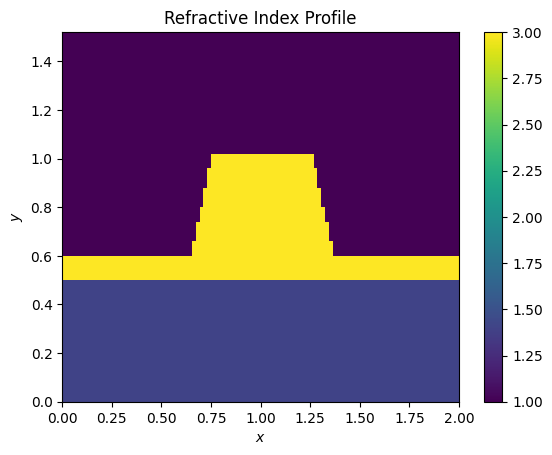

In [15]:
# All units are relative.  [um] were chosen in this case.
x_step = 0.02
y_step = 0.02
wg_height = 0.4
wg_width = 0.5
sub_height = 0.5
sub_width = 2.
clad_height = 0.5
n_sub = 1.4
n_wg = 3.
n_clad = 1.
film_thickness = 0.5
wavelength = 1.55
angle = 75.

structure = st.RidgeWaveguide(wavelength,
                              x_step,
                              y_step,
                              wg_height,
                              wg_width,
                              sub_height,
                              sub_width,
                              clad_height,
                              n_sub,
                              n_wg,
                              angle,
                              n_clad,
                              film_thickness)

structure.write_to_file('example_structure_1.dat')

In [16]:
mode_solver = ms.ModeSolverSemiVectorial(2, semi_vectorial_method='Ey')

In [17]:
mode_solver.solve(structure)

{'n_effs': array([2.47422827-8.64998379e-10j, 1.88237837-2.13690963e-06j]),
 'modes': [array([[7.57464979e-08, 1.53397797e-07, 2.34881854e-07, ...,
          2.75700819e-07, 1.80098580e-07, 8.89457429e-08],
         [1.52141661e-07, 3.08104178e-07, 4.71800234e-07, ...,
          5.53911598e-07, 3.61815477e-07, 1.78684533e-07],
         [2.29812655e-07, 4.65431584e-07, 7.12783465e-07, ...,
          8.37114067e-07, 5.46752136e-07, 2.70000462e-07],
         ...,
         [5.68215341e-07, 1.14978878e-06, 1.75829640e-06, ...,
          2.05428515e-06, 1.34384974e-06, 6.64266533e-07],
         [3.77537896e-07, 7.63906034e-07, 1.16806720e-06, ...,
          1.36417168e-06, 8.92492133e-07, 4.41197885e-07],
         [1.88382746e-07, 3.81158400e-07, 5.82770433e-07, ...,
          6.80456456e-07, 4.45215851e-07, 2.20094270e-07]]),
  array([[ 1.16084271e-06+7.49069502e-07j,  2.34570768e-06+1.50093826e-06j,
           3.56054608e-06+2.20920839e-06j, ...,
          -3.93377542e-06-2.36053466e-06j, 

[array([[7.57464979e-08, 1.53397797e-07, 2.34881854e-07, ...,
         2.75700819e-07, 1.80098580e-07, 8.89457429e-08],
        [1.52141661e-07, 3.08104178e-07, 4.71800234e-07, ...,
         5.53911598e-07, 3.61815477e-07, 1.78684533e-07],
        [2.29812655e-07, 4.65431584e-07, 7.12783465e-07, ...,
         8.37114067e-07, 5.46752136e-07, 2.70000462e-07],
        ...,
        [5.68215341e-07, 1.14978878e-06, 1.75829640e-06, ...,
         2.05428515e-06, 1.34384974e-06, 6.64266533e-07],
        [3.77537896e-07, 7.63906034e-07, 1.16806720e-06, ...,
         1.36417168e-06, 8.92492133e-07, 4.41197885e-07],
        [1.88382746e-07, 3.81158400e-07, 5.82770433e-07, ...,
         6.80456456e-07, 4.45215851e-07, 2.20094270e-07]]),
 array([[ 1.16084271e-06+7.49069502e-07j,  2.34570768e-06+1.50093826e-06j,
          3.56054608e-06+2.20920839e-06j, ...,
         -3.93377542e-06-2.36053466e-06j, -2.62844230e-06-1.54064804e-06j,
         -1.31566601e-06-7.66929068e-07j],
        [ 2.34362536e-06+

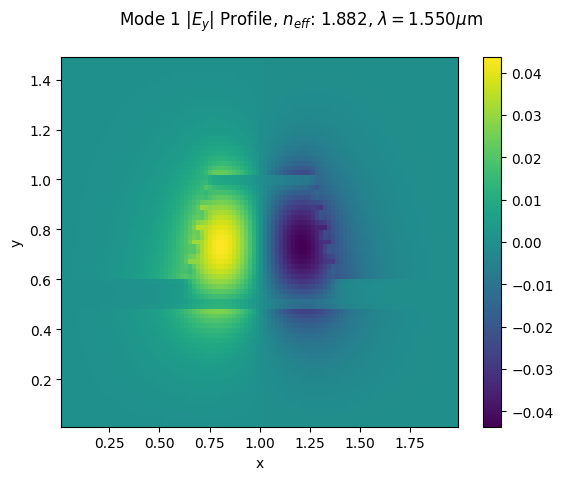

In [18]:
mode_solver.write_modes_to_file('example_modes_1.dat')

# TEST 2
The following looks at a contrived ridge waveguide in Z-cut KTP.

The simulation outputs:
* 5 plots for each refractive index axis (n_xx, n_xy, n_yx, n_yy and n_zz),
* 48 plots for Ex, Ey, Ez, Hx, Hy and Hz,
* 8 effective index values, one for each mode,
a wavelength sweep of the waveguide (plotting n_eff vs wavelength for each mode),
* whether a mode is qTE or qTM and the percentage overlap with TE and TM, and
the group velocity of the mode.


The waveguide parameters are:
* thin-film thickness: 1.2um,
* waveguide height: 800nm,
* waveguide width: 1.2um,
* refractive index of waveguide: used Sellmeier equations to get n_xx, n_yy, n_zz at 1550nm,
* refractive index of substrate: used Sellmeier equation to get SiO2 at 1550nm,
* refractive index of cladding: 1, and
* wavelength: 1550nm.

100%|█████████████████████████████████| 21/21 [00:27<00:00,  1.30s/it]


[array([1.64866193, 1.64581734, 1.58951002, 1.58518094, 1.51457252,
        1.49760798, 1.46417366, 1.45397616]),
 array([1.64825054, 1.64532173, 1.58875262, 1.58433776, 1.5134738 ,
        1.49631871, 1.46286197, 1.45261824]),
 array([1.64783863, 1.64482532, 1.58799399, 1.58349312, 1.51237405,
        1.49502817, 1.46154991, 1.45127423]),
 array([1.64742622, 1.64432811, 1.58723414, 1.58264703, 1.5112733 ,
        1.49373637, 1.46023664, 1.44991779]),
 array([1.6470133 , 1.64383011, 1.58647308, 1.58179948, 1.51017153,
        1.49244335, 1.4589208 , 1.44856926]),
 array([1.64659988, 1.64333131, 1.58571081, 1.5809505 , 1.50906876,
        1.4911491 , 1.45760494, 1.44721369]),
 array([1.64618595, 1.64283173, 1.58494733, 1.58010008, 1.50796498,
        1.48985366, 1.45628802, 1.44585772]),
 array([1.64577152, 1.64233137, 1.58418264, 1.57924823, 1.5068602 ,
        1.48855706, 1.45496906, 1.44451008]),
 array([1.6453566 , 1.64183023, 1.58341676, 1.57839496, 1.50575443,
        1.48725929, 

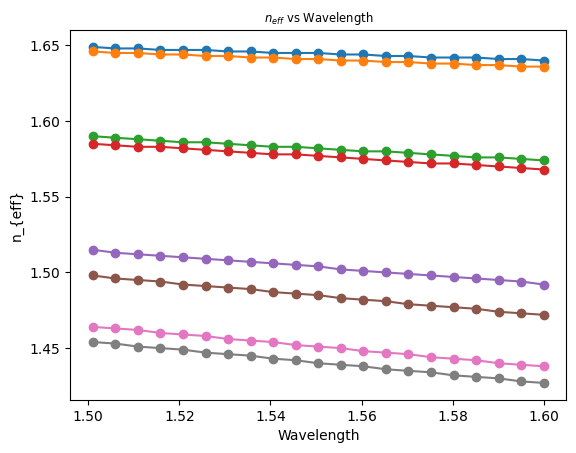

In [36]:
import mode_solver as ms
import structure as st
import structure_base as sb
import design as de
#import opticalmaterialspy as mat
import _material as mat
import numpy as np

wl = 1.55
x_step = 0.06
y_step = 0.06
wg_height = 0.8
wg_width = 1.8
sub_height = 1.0
sub_width = 4.
clad_height = 1.0
film_thickness = 1.2
angle = 60.

def struct_func(n_sub, n_wg, n_clad):
    return st.RidgeWaveguide(wl, x_step, y_step, wg_height, wg_width,
                             sub_height, sub_width, clad_height,
                             n_sub, n_wg, angle, n_clad, film_thickness)

n_sub = mat.SiO2().n(wl)
n_wg_xx = mat.Ktp('x').n(wl)
n_wg_yy = mat.Ktp('y').n(wl)
n_wg_zz = mat.Ktp('z').n(wl)
n_clad = mat.Air().n()

struct_xx = struct_func(n_sub, n_wg_xx, n_clad)
struct_yy = struct_func(n_sub, n_wg_yy, n_clad)
struct_zz = struct_func(n_sub, n_wg_zz, n_clad)

struct_ani = sb.StructureAni(struct_xx, struct_yy, struct_zz)
struct_ani.write_to_file()

solver = ms.ModeSolverFullyVectorial(8)
solver.solve(struct_ani)
solver.write_modes_to_file()

solver.solve_ng(struct_ani, 0.01)

solver.solve_sweep_wavelength(struct_ani, np.linspace(1.501, 1.60, 21))

In [38]:
import pandas as pd

df = pd.read_csv('dc-sweep-1550nm-TE-220nm-etch-220-film.dat', delimiter=',')  # Change delimiter if needed
print(df)

      # Coupling lengths (50\%)
0.10                   6.056054
0.14                   9.167756
0.18                  13.263014
0.22                  18.836443
0.26                  26.561185
0.30                  37.278339
0.34                  52.209683
0.38                  73.143442
0.42                 102.094422
0.46                 142.334725
0.50                 199.040671


In [37]:
!ls

_analyse.py				    example_structure_1.dat  mode_solver.py
dc-sweep-1500nm-TE-220nm-etch-220-film.dat  example_structure_1.png  modes_semi_vec
dc-sweep-1550nm-TE-220nm-etch-220-film.dat  _material_ani.py	     __pycache__
dc-sweep-1600nm-TE-220nm-etch-220-film.dat  _material_base.py	     sample_data
dc-sweep-TE-70nm-etch-220-film.dat	    material_index	     start_n_profile.dat
design.py				    _material.py	     start_n_profile.png
end_n_profile.dat			    modes_full_vec	     structure_base.py
end_n_profile.png			    _mode_solver_lib.py      structure.py


In [39]:
df = pd.read_csv('./modes_full_vec/ng.dat', delimiter=',')  # Change delimiter if needed
print(df)

   # Mode idx   Group index
0           0         1.775
1           1         1.798
2           2         1.823
3           3         1.845
4           4         1.851
5           5         1.892
6           6         1.865
7           7         1.864


In [41]:
!ls ./modes_full_vec/.

fraction_te.dat  mode_0  mode_4  mode_info	       structure_n_effs.png
fraction_te.png  mode_1  mode_5  mode_types.dat        wavelength_n_effs.dat
fraction_tm.dat  mode_2  mode_6  ng.dat		       wavelength_n_effs.png
fraction_tm.png  mode_3  mode_7  structure_n_effs.dat


In [42]:
df = pd.read_csv('./modes_full_vec/mode_info', delimiter=',')  # Change delimiter if needed
print(df)

   # Mode idx  Mode type   % in major direction   n_eff
0           0        qTE                  97.51   1.645
1           1        qTM                  92.58   1.641
2           2        qTE                  90.96   1.582
3           3        qTM                  91.35   1.577
4           4        qTE                  88.10   1.504
5           5        qTM                  87.69   1.485
6           6        qTE                  91.14   1.451
7           7        qTM                  61.99   1.441


# Test 3: Grating-coupler period

Analytic calculation of the grating coupler period for various duty-cycles in SOI.

Seems to match well with the periods in Taillaert et al., Grating Couplers for Coupling between Optical Fibers and Nanophotonic Waveguides, IOP Science, 2006.

http://iopscience.iop.org/article/10.1143/JJAP.45.6071/meta

In [31]:
import mode_solver as ms
import structure as st
import structure_base as sb
import design as de
import opticalmaterialspy as mat
import numpy as np

wls = [1.5, 1.55, 1.6]
x_step = 0.05
y_step = 0.05
etch_depth = 0.07
wg_width = 10
sub_height = 0.5
sub_width = 14.
clad_height = 0.5
film_thickness = 0.22
polarisation = 'TE'
dcs = np.linspace(20, 80, 61) / 100

ed1 = etch_depth
ft1 = film_thickness
ed2 = ft1 - ed1
ft2 = ed2

periods = []
periods.append(dcs)
iperiods = np.zeros((len(wls),len(dcs)))

for iwl in range(len(wls)):
    wl = wls[iwl]
    ngc = []
    for ed, ft in [(ed1, ft1), (ed2, ft2)]:
        def struct_func(n_sub, n_wg, n_clad):
            return st.RidgeWaveguide(wl, x_step, y_step, ed, wg_width,
                                     sub_height, sub_width, clad_height,
                                     n_sub, n_wg, None, n_clad, ft)

        n_sub = mat.SiO2().n(wl)
        n_wg_xx = 3.46
        n_wg_yy = 3.46
        n_wg_zz = 3.46
        n_clad = mat.Air().n()

        struct_xx = struct_func(n_sub, n_wg_xx, n_clad)
        struct_yy = struct_func(n_sub, n_wg_yy, n_clad)
        struct_zz = struct_func(n_sub, n_wg_zz, n_clad)

        struct_ani = sb.StructureAni(struct_xx, struct_yy, struct_zz)
        #struct_ani.write_to_file()

        solver = ms.ModeSolverFullyVectorial(4)
        solver.solve(struct_ani)
        #solver.write_modes_to_file()

        if polarisation == 'TE':
            ngc.append(np.round(np.real(solver.n_effs_te), 4)[0])
        elif polarisation == 'TM':
            ngc.append(np.round(np.real(solver.n_effs_tm), 4)[0])

    period = de.grating_coupler_period(wl, dcs*ngc[0]+(1-dcs)*ngc[1], n_clad, 8, 1)
    iperiods[iwl,:] = period
    periods.append(period)


filename = 'dc-sweep-%s-%inm-etch-%i-film.dat' % (polarisation, etch_depth*1000, film_thickness*1000)
np.savetxt(filename, np.array(periods).T, delimiter=',', header=','.join([str(val) for val in wls]))
print(np.c_[periods])

[[0.2        0.21       0.22       0.23       0.24       0.25
  0.26       0.27       0.28       0.29       0.3        0.31
  0.32       0.33       0.34       0.35       0.36       0.37
  0.38       0.39       0.4        0.41       0.42       0.43
  0.44       0.45       0.46       0.47       0.48       0.49
  0.5        0.51       0.52       0.53       0.54       0.55
  0.56       0.57       0.58       0.59       0.6        0.61
  0.62       0.63       0.64       0.65       0.66       0.67
  0.68       0.69       0.7        0.71       0.72       0.73
  0.74       0.75       0.76       0.77       0.78       0.79
  0.8       ]
 [0.62763951 0.62647721 0.6253192  0.62416547 0.62301598 0.62187072
  0.62072966 0.61959279 0.61846007 0.61733148 0.61620701 0.61508662
  0.61397031 0.61285803 0.61174978 0.61064553 0.60954526 0.60844895
  0.60735657 0.60626811 0.60518354 0.60410285 0.60302601 0.601953
  0.6008838  0.5998184  0.59875677 0.59769888 0.59664473 0.59559429
  0.59454755 0.59350447 0.59

In [32]:
import matplotlib as mpl
mpl.rcParams['figure.dpi']=100
import matplotlib.pylab as plt

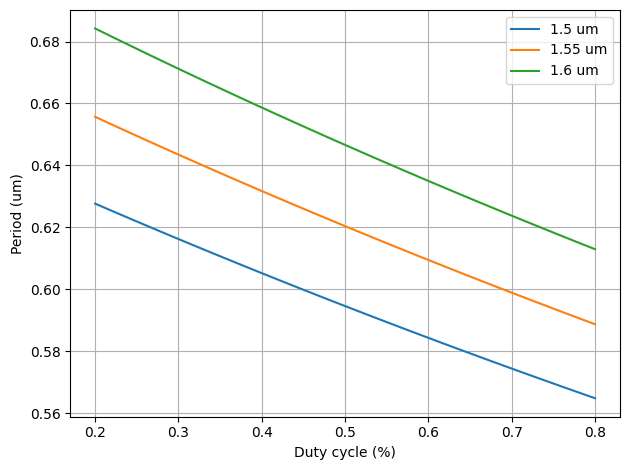

In [33]:
plt.plot(dcs,iperiods[0,:],label='1.5 um')
plt.plot(dcs,iperiods[1,:],label='1.55 um')
plt.plot(dcs,iperiods[2,:],label='1.6 um')
plt.xlabel('Duty cycle (%)')
plt.ylabel('Period (um)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

#Test 4

In [25]:
import mode_solver as ms
import structure as st
import opticalmaterialspy as mat
import numpy as np

100%|█████████████████████████████████| 34/34 [06:54<00:00, 12.20s/it]


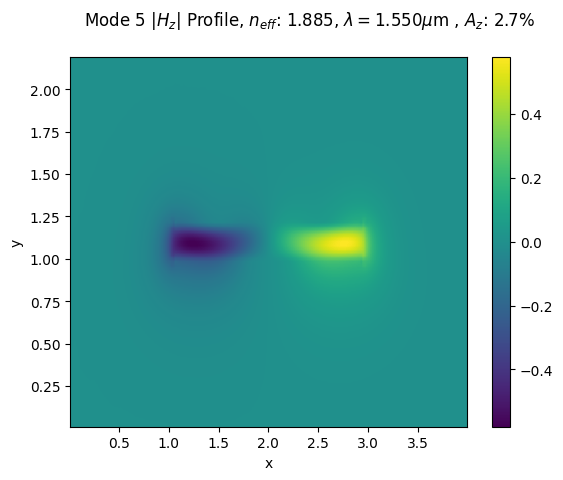

In [26]:
wl = 1.55
x_step = 0.02
y_step = 0.02
etch_depth = 0.22
wg_widths = np.arange(0.3, 2., 0.05)
sub_height = 1.
sub_width = 4.
clad_height = 1.
film_thickness = 0.22

n_sub = mat.SiO2().n(wl)
n_clad = mat.Air().n(wl)
n_wg = 3.4757 #mat.RefractiveIndexWeb('https://refractiveindex.info/?shelf=main&book=Si&page=Li-293K').n(wl)

r = []
for w in wg_widths:
    r.append(
        st.RidgeWaveguide(wl, x_step, y_step, etch_depth, w, sub_height,
                          sub_width, clad_height, n_sub, n_wg, None, n_clad,
                          film_thickness))

r[0].write_to_file('start_n_profile.dat')
r[-1].write_to_file('end_n_profile.dat')

solver = ms.ModeSolverFullyVectorial(6)
solver.solve_sweep_structure(r, wg_widths, x_label='Taper width', fraction_mode_list=[1,2])
solver.write_modes_to_file()

In [27]:
!ls

_analyse.py				    example_structure_1.dat  modes_semi_vec
dc-sweep-1500nm-TE-220nm-etch-220-film.dat  example_structure_1.png  __pycache__
dc-sweep-1550nm-TE-220nm-etch-220-film.dat  _material_ani.py	     sample_data
dc-sweep-1600nm-TE-220nm-etch-220-film.dat  _material_base.py	     start_n_profile.dat
dc-sweep-TE-70nm-etch-220-film.dat	    _material.py	     start_n_profile.png
design.py				    modes_full_vec	     structure_base.py
end_n_profile.dat			    _mode_solver_lib.py      structure.py
end_n_profile.png			    mode_solver.py


In [30]:
import sys, inspect
inspect.getmembers(solver)

[('__abstractmethods__', frozenset()),
 ('__class__', mode_solver.ModeSolverFullyVectorial),
 ('__delattr__',
  <method-wrapper '__delattr__' of ModeSolverFullyVectorial object at 0x7e92aceda6b0>),
 ('__dict__',
  {'n_effs_te': [(2.7931022308791738+8.331126767200423e-17j),
    (2.7069014319582743-1.256966333755048e-14j),
    (2.557259573387427+2.582732624230481e-12j),
    (2.3331963597229954-1.466181580582444e-10j),
    (2.0143439647569754+5.353238627609142e-07j)],
   'n_effs_tm': [(1.884872757890726+9.426838660948621e-06j)],
   '_n_eigs': 6,
   '_tol': 0.001,
   '_boundary': '0000',
   '_mode_profiles': False,
   '_initial_mode_guess': None,
   '_n_eff_guess': None,
   'n_effs': array([2.79310223+8.33112677e-17j, 2.70690143-1.25696633e-14j,
          2.55725957+2.58273262e-12j, 2.33319636-1.46618158e-10j,
          2.01434396+5.35323863e-07j, 1.88487276+9.42683866e-06j]),
   'modes': [<_mode_solver_lib.FDMode at 0x7e92acedab60>,
   'mode_types': [('qTE', 97.85),
    ('qTE', 91.47),
  

# Test 5

In [22]:
import mode_solver as ms
import structure as st
import design as de
import opticalmaterialspy as mat
import numpy as np
import tqdm
import scipy
import matplotlib as mpl
mpl.rcParams['figure.dpi']=100
import matplotlib.pylab as plt

In [23]:
wls = [1.5, 1.55, 1.6]
x_step = 0.02
y_step = 0.02
etch_depth = 0.22
wg_width = 0.44
sub_height = 0.5
sub_width = 2.
clad_height = 0.5
film_thickness = 0.22
gaps = np.linspace(0.1, 0.5, 11)
n_Si = [3.4799, 3.476, 3.4719]

coupling_lengths = np.zeros((len(wls),len(gaps)))
for iwl in range(len(wls)):
    wl = wls[iwl]
    lengths = []

    n_sub = mat.SiO2().n(wl)
    n_clad = mat.Air().n(wl)
    n_wg = n_Si[iwl]

    for igap in range(len(gaps)):
        gap = gaps[igap]
        r = st.WgArray(wl, x_step, y_step, etch_depth, [wg_width, wg_width], gap,
                       sub_height, sub_width, clad_height, n_sub, n_wg, None)
        #r.write_to_file()

        solver = ms.ModeSolverFullyVectorial(2)
        solver.solve(r)
        n1 = solver.n_effs_te[0]
        n2 = solver.n_effs_te[1]
        coupling_lengths[iwl,igap] = de.directional_coupler_lc(wl*1000, n1, n2)/2
        lengths.append(de.directional_coupler_lc(wl*1000, n1, n2)/2)

    filename = 'dc-sweep-%inm-%s-%inm-etch-%i-film.dat' % (wl*1000, 'TE', etch_depth*1000, film_thickness*1000)
    np.savetxt(filename, np.c_[gaps, lengths], delimiter=',', header='Coupling lengths (50\%)')

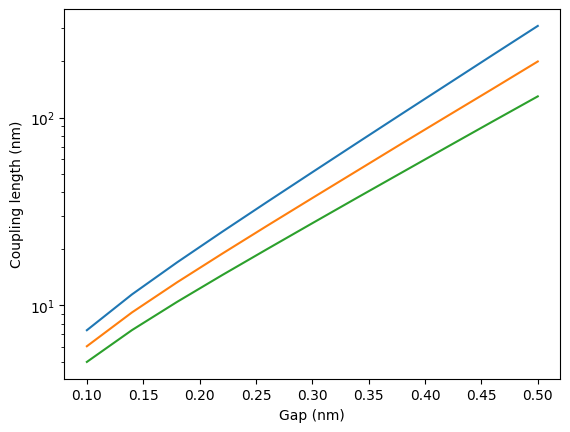

In [24]:
plt.semilogy(gaps,coupling_lengths[0,:])
plt.semilogy(gaps,coupling_lengths[1,:])
plt.semilogy(gaps,coupling_lengths[2,:])
plt.xlabel('Gap (nm)')
plt.ylabel('Coupling length (nm)')
plt.show()